In [1]:
# Import all the required libraries and machine learning models

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, BatchNormalization, Dropout # LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import xgboost as xgb
from catboost import CatBoostClassifier
from matplotlib import pyplot


Using TensorFlow backend.


In [2]:
# Import the data files for further analysis

df = pd.read_csv('train.csv')               # Original train data set
pca_train = pd.read_csv('pca_train.csv')    # Principal Components collected for train data set. See ->
pca_test = pd.read_csv('pca_test.csv')      # Prinscipal Components collected for test data set. See ->
alldf = pd.read_csv('alldata.csv')          # The whole Train-Test dataset in combined form
alldf.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [3]:
## Data Pre-processing!
# Convert the categorical variables to numbers and take care of null values

df1 = alldf.copy(deep=True)
df1['Gender'] = df1['Gender'].map(lambda x: 1 if x == 'Male' else 0)
df1['Married'] = df1['Married'].map(lambda x: 1 if x == 'Yes' else 0)
df1['Dependents'] = df1['Dependents'].map(lambda x: 3 if x == '3+' else float(x))
df1['Dependents'] = df1['Dependents'].fillna(df1['Dependents'].mean())#value=0)
df1['Education'] = df1['Education'].map(lambda x: 1 if x == 'Graduate' else 0)
df1['Self_Employed'] = df1['Self_Employed'].map(lambda x: 1 if x == 'Yes' else 0)
df1['LoanAmount'] = df1['LoanAmount'].fillna(df1['LoanAmount'].mean())
df1['Loan_Amount_Term'] = df1['Loan_Amount_Term'].fillna(df1['Loan_Amount_Term'].mean())
df1['Credit_History'] = df1['Credit_History'].fillna(df1['Credit_History'].mean())
df1['Property_Area'] = df1['Property_Area'].map(lambda x: 2 if x == 'Urban' else (1 if x == 'Semiurban' else 0))
#df1['Loan_Status'] = df1['Loan_Status'].map(lambda x: 1 if x == 'Y' else 0)
df1.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,1,0,0.0,1,0,5849,0.0,142.51153,360.0,1.0,2
1,LP001003,1,1,1.0,1,0,4583,1508.0,128.00000,360.0,1.0,0
2,LP001005,1,1,0.0,1,1,3000,0.0,66.00000,360.0,1.0,2
3,LP001006,1,1,0.0,0,0,2583,2358.0,120.00000,360.0,1.0,2
4,LP001008,1,0,0.0,1,0,6000,0.0,141.00000,360.0,1.0,2


In [4]:
# Check the structure of the data in all-dataset (First 614 rows train, last 367 rows test)
alldf.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [5]:
# Check the princinpal components for training set obtained from PCA analysis explained in the other file
pca_train.head()

,pc1,pc2,pc3,pc4,pc5,pc6
0,0.532196,-0.372043,0.305666,-0.546590,0.135447,0.009730
1,-0.389258,-0.045656,-0.573600,-0.017898,-0.057655,-0.232852
2,-0.293952,-0.467042,0.134255,-0.177374,-0.261998,0.795718
3,-0.378499,0.394433,0.677732,-0.340884,-0.220230,-0.150057
4,0.532253,-0.371999,0.305718,-0.546631,0.135432,0.009699


In [6]:
# Similarly check PCs for test dataset
pca_test.head()

,pc1,pc2,pc3,pc4,pc5,pc6
0,-0.279674,-0.482089,0.281351,-0.216091,-0.031365,-0.142948
1,-0.387792,-0.465299,0.315794,-0.105767,-0.045882,-0.094015
2,-0.499361,-0.453305,0.346596,0.008040,-0.060596,-0.039688
3,-0.492062,-0.414947,0.365367,0.070814,0.079475,-0.018593
4,0.437441,0.509004,0.706130,-0.674169,-0.054470,-0.001153


In [7]:
# Convert labels from categorical Y/N to binary numbers for Loan Elibiligy Classification
df['Loan_Status'] = df['Loan_Status'].map(lambda x: 1 if x == 'Y' else 0)

In [8]:
# Set X, y and t to input variables, target variable and test set respectively 

X = pca_train[['pc1','pc2','pc3','pc4','pc5','pc6']]       # PCs for train set
y = df['Loan_Status']                                      # Target for train set
t = pca_test[['pc1','pc2','pc3','pc4','pc5','pc6']]        # PCs for the test set
#y = to_categorical(y)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [9]:
t.shape

(367, 6)

In [10]:
X.shape

(614, 6)

In [11]:
# Define a stacking function to create predictions on the train and test data set using ML models/classifiers

def Stacking(model, train, y, test, n_fold):              # Takes input as model, X_train, y_train, t (test data) and number of folds for cross-validation
    folds = StratifiedKFold(n_splits = n_fold, random_state=1)
    test_pred = np.empty((0,1), float)
    train_pred = np.empty((0,1), float)
    train_targ = np.empty((0,1), float)
    for train_indices, val_indices in folds.split(train, y.values):
        X_train, X_val = train.loc[train_indices], train.loc[val_indices]
        y_train, y_val = y.loc[train_indices], y.loc[val_indices]

        model.fit(X_train, y_train)
        train_pred = np.append(train_pred, model.predict(X_val))    # Append the predictions made on the validation set in each fold
        train_targ = np.append(train_targ, y_val)                   # Append the corresponding validation targets
        print(model.score(X_val, y_val))                            # These predictions from ML models will be used as input in the Deep Learning model
    test_pred = np.append(test_pred, model.predict(t))              # This is how ML over DL Stacking Ensemble is created 
    return test_pred, train_pred, train_targ                        

In [12]:
# Create Ada classifier and create a new input variable 'ada' made out of validation fold predictions
# As these predictions are made on the data unseen by the model as it goes through each fold,
# it makes it a good unbiased input to be used in the ensemble of the machine/deep learning models

ada = AdaBoostClassifier(n_estimators=1)

# Train ada classifier and create input validation preditions using Stacking function
test_pred1, train_pred1, train_targ1 = Stacking(ada, X, y, t, 10)

# Create a ML_train_pred dataframe to store the corresponding targets
ML_train_pred = pd.DataFrame(train_targ1, columns=['target'])

# Add 'ada' column as preditions made on the validation set during the ML training
ML_train_pred['ada'] = train_pred1

# Similarly add preditions made on the test set using ada in a new ML_test_pred dataframe
ML_test_pred = pd.DataFrame(test_pred1,columns=['ada'])
ML_train_pred.head()

0.7777777777777778
0.8412698412698413
0.7868852459016393
0.7704918032786885
0.7868852459016393
0.7868852459016393
0.8852459016393442
0.8524590163934426
0.819672131147541
0.819672131147541


,target,ada
0,1.0,1.0
1,0.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


In [13]:
# Check head and tail for consistency
ML_train_pred.tail()

,target,ada
609,1.0,1.0
610,1.0,1.0
611,1.0,1.0
612,1.0,1.0
613,0.0,0.0


In [14]:
# Check the length of the df
len(train_pred1)

614

In [15]:
# Follow the similar process as that for AdaClassifier but using different machine learning algorythms
# GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=0.005,warm_start=True, n_estimators=176)

test_pred1, train_pred1, train_targ1 = Stacking(gbc, X, y, t, 10)

ML_train_pred['gbc'] = train_pred1
ML_test_pred['gbc'] = test_pred1
ML_train_pred.head()

0.7777777777777778
0.8888888888888888
0.8360655737704918
0.7704918032786885
0.8032786885245902
0.8032786885245902
0.8852459016393442
0.8524590163934426
0.819672131147541
0.8524590163934426


,target,ada,gbc
0,1.0,1.0,1.0
1,0.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [16]:
# BaggingClassifier using DecisionTreeClassifier as the Best Estimator parameter

bcdt = BaggingClassifier(DecisionTreeClassifier(random_state=1), n_estimators=43)

test_pred1, train_pred1, train_targ1 = Stacking(bcdt, X, y, t, 10)

ML_train_pred['bcdt'] = train_pred1
ML_test_pred['bcdt'] = test_pred1
ML_train_pred.head()

0.6984126984126984
0.7777777777777778
0.7213114754098361
0.7377049180327869
0.6885245901639344
0.7213114754098361
0.8032786885245902
0.7213114754098361
0.6885245901639344
0.8032786885245902


,target,ada,gbc,bcdt
0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0


In [17]:
# DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=1)

test_pred1, train_pred1, train_targ1 = Stacking(dt, X, y, t, 10)

ML_train_pred['dt'] = train_pred1
ML_test_pred['dt'] = test_pred1
ML_train_pred.head()

0.6825396825396826
0.6666666666666666
0.6557377049180327
0.7213114754098361
0.7213114754098361
0.7540983606557377
0.7540983606557377
0.6065573770491803
0.6229508196721312
0.7704918032786885


,target,ada,gbc,bcdt,dt
0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0


In [18]:
ML_test_pred.tail()

,ada,gbc,bcdt,dt
362,1.0,1.0,1.0,1.0
363,1.0,1.0,1.0,1.0
364,0.0,0.0,0.0,0.0
365,1.0,1.0,1.0,1.0
366,1.0,1.0,1.0,0.0


In [19]:
# LinearSVC

svc = LinearSVC(random_state=1)

test_pred1, train_pred1, train_targ1 = Stacking(svc, X, y, t, 10)

ML_train_pred['svc'] = train_pred1
ML_test_pred['svc'] = test_pred1
ML_train_pred.head()

0.7936507936507936
0.8253968253968254
0.7868852459016393
0.7540983606557377
0.7868852459016393
0.7868852459016393
0.8688524590163934
0.8524590163934426
0.8032786885245902
0.8360655737704918


,target,ada,gbc,bcdt,dt,svc
0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0


In [20]:
ML_test_pred.tail()

,ada,gbc,bcdt,dt,svc
362,1.0,1.0,1.0,1.0,1.0
363,1.0,1.0,1.0,1.0,1.0
364,0.0,0.0,0.0,0.0,1.0
365,1.0,1.0,1.0,1.0,1.0
366,1.0,1.0,1.0,0.0,1.0


In [21]:
# XGBM Boosting Ensemble Classifier

xg = xgb.XGBClassifier(random_state=1,learning_rate=0.005)

test_pred1, train_pred1, train_targ1 = Stacking(xg, X, y, t, 10)

ML_train_pred['xg'] = train_pred1
ML_test_pred['xg'] = test_pred1
ML_train_pred.head()

0.7777777777777778
0.8412698412698413
0.7868852459016393
0.7704918032786885
0.7377049180327869
0.7868852459016393
0.8852459016393442
0.8360655737704918
0.819672131147541
0.819672131147541


,target,ada,gbc,bcdt,dt,svc,xg
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
# CatBoostClassifier

cbc = CatBoostClassifier(random_state=1, iterations=2000)

test_pred1, train_pred1, train_targ1 = Stacking(cbc, X, y, t, 10)

ML_train_pred['cbc'] = train_pred1
ML_test_pred['cbc'] = test_pred1
ML_train_pred.head()

Learning rate set to 0.00423
0:	learn: 0.6908051	total: 58ms	remaining: 1m 55s
1:	learn: 0.6884871	total: 61.4ms	remaining: 1m 1s
2:	learn: 0.6863312	total: 64.6ms	remaining: 43s
3:	learn: 0.6841411	total: 67.8ms	remaining: 33.8s
4:	learn: 0.6819177	total: 71.3ms	remaining: 28.4s
5:	learn: 0.6798162	total: 74.5ms	remaining: 24.8s
6:	learn: 0.6777877	total: 77.7ms	remaining: 22.1s
7:	learn: 0.6756176	total: 81.1ms	remaining: 20.2s
8:	learn: 0.6735400	total: 84.4ms	remaining: 18.7s
9:	learn: 0.6714130	total: 87.7ms	remaining: 17.5s
10:	learn: 0.6694728	total: 91.1ms	remaining: 16.5s
11:	learn: 0.6674187	total: 94.3ms	remaining: 15.6s
12:	learn: 0.6655759	total: 97.7ms	remaining: 14.9s
13:	learn: 0.6634571	total: 101ms	remaining: 14.3s
14:	learn: 0.6615393	total: 104ms	remaining: 13.8s
15:	learn: 0.6596220	total: 108ms	remaining: 13.3s
16:	learn: 0.6575324	total: 111ms	remaining: 12.9s
17:	learn: 0.6555875	total: 114ms	remaining: 12.6s
18:	learn: 0.6534919	total: 117ms	remaining: 12.2s
19

176:	learn: 0.4890475	total: 658ms	remaining: 6.78s
177:	learn: 0.4885889	total: 661ms	remaining: 6.77s
178:	learn: 0.4880806	total: 664ms	remaining: 6.76s
179:	learn: 0.4875987	total: 667ms	remaining: 6.75s
180:	learn: 0.4870399	total: 670ms	remaining: 6.74s
181:	learn: 0.4864893	total: 674ms	remaining: 6.73s
182:	learn: 0.4860280	total: 677ms	remaining: 6.72s
183:	learn: 0.4856035	total: 680ms	remaining: 6.71s
184:	learn: 0.4850960	total: 684ms	remaining: 6.71s
185:	learn: 0.4846655	total: 689ms	remaining: 6.72s
186:	learn: 0.4841315	total: 693ms	remaining: 6.71s
187:	learn: 0.4836592	total: 697ms	remaining: 6.71s
188:	learn: 0.4831381	total: 701ms	remaining: 6.72s
189:	learn: 0.4826701	total: 704ms	remaining: 6.71s
190:	learn: 0.4822986	total: 707ms	remaining: 6.7s
191:	learn: 0.4817254	total: 710ms	remaining: 6.69s
192:	learn: 0.4812274	total: 713ms	remaining: 6.68s
193:	learn: 0.4807703	total: 718ms	remaining: 6.68s
194:	learn: 0.4801832	total: 721ms	remaining: 6.67s
195:	learn: 0

370:	learn: 0.4293197	total: 1.31s	remaining: 5.78s
371:	learn: 0.4291722	total: 1.32s	remaining: 5.77s
372:	learn: 0.4289979	total: 1.32s	remaining: 5.77s
373:	learn: 0.4288370	total: 1.33s	remaining: 5.76s
374:	learn: 0.4286570	total: 1.33s	remaining: 5.76s
375:	learn: 0.4284226	total: 1.33s	remaining: 5.76s
376:	learn: 0.4282529	total: 1.34s	remaining: 5.76s
377:	learn: 0.4280631	total: 1.34s	remaining: 5.76s
378:	learn: 0.4278929	total: 1.34s	remaining: 5.75s
379:	learn: 0.4276573	total: 1.35s	remaining: 5.75s
380:	learn: 0.4274170	total: 1.35s	remaining: 5.75s
381:	learn: 0.4272534	total: 1.35s	remaining: 5.74s
382:	learn: 0.4271265	total: 1.36s	remaining: 5.74s
383:	learn: 0.4269458	total: 1.36s	remaining: 5.73s
384:	learn: 0.4268129	total: 1.36s	remaining: 5.72s
385:	learn: 0.4266496	total: 1.37s	remaining: 5.72s
386:	learn: 0.4264556	total: 1.37s	remaining: 5.71s
387:	learn: 0.4262605	total: 1.37s	remaining: 5.71s
388:	learn: 0.4260961	total: 1.38s	remaining: 5.7s
389:	learn: 0

567:	learn: 0.4000293	total: 1.97s	remaining: 4.96s
568:	learn: 0.3999179	total: 1.97s	remaining: 4.96s
569:	learn: 0.3998083	total: 1.98s	remaining: 4.96s
570:	learn: 0.3997258	total: 1.98s	remaining: 4.96s
571:	learn: 0.3996262	total: 1.98s	remaining: 4.95s
572:	learn: 0.3994787	total: 1.99s	remaining: 4.95s
573:	learn: 0.3993175	total: 1.99s	remaining: 4.95s
574:	learn: 0.3992130	total: 1.99s	remaining: 4.94s
575:	learn: 0.3990496	total: 2s	remaining: 4.94s
576:	learn: 0.3989000	total: 2s	remaining: 4.94s
577:	learn: 0.3988375	total: 2s	remaining: 4.93s
578:	learn: 0.3987265	total: 2.01s	remaining: 4.93s
579:	learn: 0.3985764	total: 2.01s	remaining: 4.92s
580:	learn: 0.3984645	total: 2.01s	remaining: 4.92s
581:	learn: 0.3983426	total: 2.02s	remaining: 4.92s
582:	learn: 0.3982496	total: 2.02s	remaining: 4.91s
583:	learn: 0.3981500	total: 2.02s	remaining: 4.91s
584:	learn: 0.3980614	total: 2.03s	remaining: 4.9s
585:	learn: 0.3979618	total: 2.03s	remaining: 4.9s
586:	learn: 0.3978938	t

770:	learn: 0.3797523	total: 2.63s	remaining: 4.18s
771:	learn: 0.3795787	total: 2.63s	remaining: 4.18s
772:	learn: 0.3794304	total: 2.63s	remaining: 4.18s
773:	learn: 0.3793680	total: 2.63s	remaining: 4.17s
774:	learn: 0.3792584	total: 2.64s	remaining: 4.17s
775:	learn: 0.3791588	total: 2.64s	remaining: 4.17s
776:	learn: 0.3790174	total: 2.65s	remaining: 4.16s
777:	learn: 0.3789881	total: 2.65s	remaining: 4.16s
778:	learn: 0.3788601	total: 2.65s	remaining: 4.16s
779:	learn: 0.3787704	total: 2.66s	remaining: 4.15s
780:	learn: 0.3787030	total: 2.66s	remaining: 4.15s
781:	learn: 0.3786416	total: 2.66s	remaining: 4.15s
782:	learn: 0.3785264	total: 2.67s	remaining: 4.14s
783:	learn: 0.3784791	total: 2.67s	remaining: 4.14s
784:	learn: 0.3783891	total: 2.67s	remaining: 4.13s
785:	learn: 0.3782933	total: 2.67s	remaining: 4.13s
786:	learn: 0.3782092	total: 2.68s	remaining: 4.13s
787:	learn: 0.3781364	total: 2.68s	remaining: 4.12s
788:	learn: 0.3780259	total: 2.68s	remaining: 4.12s
789:	learn: 

974:	learn: 0.3630471	total: 3.28s	remaining: 3.45s
975:	learn: 0.3630117	total: 3.29s	remaining: 3.45s
976:	learn: 0.3629571	total: 3.29s	remaining: 3.44s
977:	learn: 0.3628659	total: 3.29s	remaining: 3.44s
978:	learn: 0.3628381	total: 3.3s	remaining: 3.44s
979:	learn: 0.3627254	total: 3.3s	remaining: 3.43s
980:	learn: 0.3626241	total: 3.3s	remaining: 3.43s
981:	learn: 0.3625728	total: 3.31s	remaining: 3.43s
982:	learn: 0.3625393	total: 3.31s	remaining: 3.42s
983:	learn: 0.3624418	total: 3.31s	remaining: 3.42s
984:	learn: 0.3623904	total: 3.32s	remaining: 3.42s
985:	learn: 0.3622988	total: 3.32s	remaining: 3.41s
986:	learn: 0.3622075	total: 3.32s	remaining: 3.41s
987:	learn: 0.3621437	total: 3.33s	remaining: 3.41s
988:	learn: 0.3620378	total: 3.33s	remaining: 3.4s
989:	learn: 0.3619570	total: 3.33s	remaining: 3.4s
990:	learn: 0.3618723	total: 3.34s	remaining: 3.4s
991:	learn: 0.3618190	total: 3.34s	remaining: 3.39s
992:	learn: 0.3617328	total: 3.34s	remaining: 3.39s
993:	learn: 0.3616

1172:	learn: 0.3484510	total: 3.93s	remaining: 2.77s
1173:	learn: 0.3483520	total: 3.94s	remaining: 2.77s
1174:	learn: 0.3483059	total: 3.94s	remaining: 2.77s
1175:	learn: 0.3482240	total: 3.94s	remaining: 2.76s
1176:	learn: 0.3481524	total: 3.95s	remaining: 2.76s
1177:	learn: 0.3480626	total: 3.95s	remaining: 2.76s
1178:	learn: 0.3480360	total: 3.95s	remaining: 2.75s
1179:	learn: 0.3479709	total: 3.96s	remaining: 2.75s
1180:	learn: 0.3479077	total: 3.96s	remaining: 2.75s
1181:	learn: 0.3478500	total: 3.96s	remaining: 2.74s
1182:	learn: 0.3477647	total: 3.97s	remaining: 2.74s
1183:	learn: 0.3477334	total: 3.97s	remaining: 2.74s
1184:	learn: 0.3476207	total: 3.98s	remaining: 2.73s
1185:	learn: 0.3475094	total: 3.98s	remaining: 2.73s
1186:	learn: 0.3474242	total: 3.98s	remaining: 2.73s
1187:	learn: 0.3473892	total: 3.98s	remaining: 2.72s
1188:	learn: 0.3473371	total: 3.99s	remaining: 2.72s
1189:	learn: 0.3472569	total: 3.99s	remaining: 2.72s
1190:	learn: 0.3471689	total: 3.99s	remaining:

1375:	learn: 0.3347171	total: 4.59s	remaining: 2.08s
1376:	learn: 0.3346271	total: 4.59s	remaining: 2.08s
1377:	learn: 0.3345628	total: 4.59s	remaining: 2.07s
1378:	learn: 0.3345217	total: 4.6s	remaining: 2.07s
1379:	learn: 0.3344656	total: 4.6s	remaining: 2.07s
1380:	learn: 0.3344075	total: 4.61s	remaining: 2.06s
1381:	learn: 0.3343486	total: 4.61s	remaining: 2.06s
1382:	learn: 0.3342902	total: 4.61s	remaining: 2.06s
1383:	learn: 0.3342405	total: 4.62s	remaining: 2.06s
1384:	learn: 0.3341929	total: 4.62s	remaining: 2.05s
1385:	learn: 0.3341347	total: 4.62s	remaining: 2.05s
1386:	learn: 0.3340759	total: 4.63s	remaining: 2.04s
1387:	learn: 0.3340416	total: 4.63s	remaining: 2.04s
1388:	learn: 0.3339578	total: 4.63s	remaining: 2.04s
1389:	learn: 0.3338858	total: 4.64s	remaining: 2.04s
1390:	learn: 0.3338299	total: 4.64s	remaining: 2.03s
1391:	learn: 0.3337575	total: 4.65s	remaining: 2.03s
1392:	learn: 0.3337104	total: 4.65s	remaining: 2.03s
1393:	learn: 0.3336002	total: 4.65s	remaining: 2

1562:	learn: 0.3213792	total: 5.24s	remaining: 1.47s
1563:	learn: 0.3212672	total: 5.25s	remaining: 1.46s
1564:	learn: 0.3212051	total: 5.25s	remaining: 1.46s
1565:	learn: 0.3211419	total: 5.25s	remaining: 1.46s
1566:	learn: 0.3210872	total: 5.26s	remaining: 1.45s
1567:	learn: 0.3209642	total: 5.26s	remaining: 1.45s
1568:	learn: 0.3208979	total: 5.27s	remaining: 1.45s
1569:	learn: 0.3208277	total: 5.27s	remaining: 1.44s
1570:	learn: 0.3207600	total: 5.28s	remaining: 1.44s
1571:	learn: 0.3206818	total: 5.28s	remaining: 1.44s
1572:	learn: 0.3205851	total: 5.29s	remaining: 1.43s
1573:	learn: 0.3205260	total: 5.29s	remaining: 1.43s
1574:	learn: 0.3204390	total: 5.3s	remaining: 1.43s
1575:	learn: 0.3203794	total: 5.3s	remaining: 1.43s
1576:	learn: 0.3202925	total: 5.3s	remaining: 1.42s
1577:	learn: 0.3202438	total: 5.31s	remaining: 1.42s
1578:	learn: 0.3201330	total: 5.31s	remaining: 1.42s
1579:	learn: 0.3200348	total: 5.32s	remaining: 1.41s
1580:	learn: 0.3200077	total: 5.32s	remaining: 1.

1730:	learn: 0.3092869	total: 5.89s	remaining: 915ms
1731:	learn: 0.3091976	total: 5.89s	remaining: 912ms
1732:	learn: 0.3091523	total: 5.9s	remaining: 909ms
1733:	learn: 0.3090898	total: 5.9s	remaining: 906ms
1734:	learn: 0.3090278	total: 5.91s	remaining: 902ms
1735:	learn: 0.3089608	total: 5.91s	remaining: 899ms
1736:	learn: 0.3088931	total: 5.92s	remaining: 896ms
1737:	learn: 0.3088163	total: 5.92s	remaining: 892ms
1738:	learn: 0.3087441	total: 5.92s	remaining: 889ms
1739:	learn: 0.3087088	total: 5.93s	remaining: 885ms
1740:	learn: 0.3086693	total: 5.93s	remaining: 882ms
1741:	learn: 0.3085753	total: 5.93s	remaining: 879ms
1742:	learn: 0.3085301	total: 5.94s	remaining: 876ms
1743:	learn: 0.3084524	total: 5.94s	remaining: 872ms
1744:	learn: 0.3083787	total: 5.95s	remaining: 869ms
1745:	learn: 0.3083373	total: 5.96s	remaining: 866ms
1746:	learn: 0.3082722	total: 5.96s	remaining: 863ms
1747:	learn: 0.3082211	total: 5.96s	remaining: 860ms
1748:	learn: 0.3081866	total: 5.97s	remaining: 8

1906:	learn: 0.2970356	total: 6.54s	remaining: 319ms
1907:	learn: 0.2969866	total: 6.54s	remaining: 316ms
1908:	learn: 0.2968914	total: 6.55s	remaining: 312ms
1909:	learn: 0.2967808	total: 6.55s	remaining: 309ms
1910:	learn: 0.2966937	total: 6.56s	remaining: 305ms
1911:	learn: 0.2966295	total: 6.56s	remaining: 302ms
1912:	learn: 0.2965259	total: 6.57s	remaining: 299ms
1913:	learn: 0.2964781	total: 6.57s	remaining: 295ms
1914:	learn: 0.2964426	total: 6.58s	remaining: 292ms
1915:	learn: 0.2963850	total: 6.58s	remaining: 289ms
1916:	learn: 0.2962824	total: 6.58s	remaining: 285ms
1917:	learn: 0.2961964	total: 6.59s	remaining: 282ms
1918:	learn: 0.2961580	total: 6.59s	remaining: 278ms
1919:	learn: 0.2960977	total: 6.59s	remaining: 275ms
1920:	learn: 0.2960302	total: 6.6s	remaining: 271ms
1921:	learn: 0.2959956	total: 6.6s	remaining: 268ms
1922:	learn: 0.2959743	total: 6.6s	remaining: 264ms
1923:	learn: 0.2959341	total: 6.61s	remaining: 261ms
1924:	learn: 0.2958522	total: 6.61s	remaining: 25

88:	learn: 0.5591416	total: 295ms	remaining: 6.33s
89:	learn: 0.5582300	total: 300ms	remaining: 6.36s
90:	learn: 0.5572351	total: 303ms	remaining: 6.36s
91:	learn: 0.5563055	total: 306ms	remaining: 6.35s
92:	learn: 0.5553384	total: 310ms	remaining: 6.35s
93:	learn: 0.5544046	total: 313ms	remaining: 6.35s
94:	learn: 0.5534282	total: 316ms	remaining: 6.34s
95:	learn: 0.5524595	total: 320ms	remaining: 6.35s
96:	learn: 0.5515490	total: 324ms	remaining: 6.35s
97:	learn: 0.5506258	total: 327ms	remaining: 6.35s
98:	learn: 0.5496161	total: 330ms	remaining: 6.34s
99:	learn: 0.5488248	total: 333ms	remaining: 6.33s
100:	learn: 0.5479337	total: 337ms	remaining: 6.33s
101:	learn: 0.5470914	total: 340ms	remaining: 6.33s
102:	learn: 0.5463062	total: 344ms	remaining: 6.33s
103:	learn: 0.5454008	total: 349ms	remaining: 6.36s
104:	learn: 0.5444388	total: 352ms	remaining: 6.35s
105:	learn: 0.5436356	total: 356ms	remaining: 6.36s
106:	learn: 0.5428747	total: 361ms	remaining: 6.38s
107:	learn: 0.5419954	to

258:	learn: 0.4640360	total: 946ms	remaining: 6.36s
259:	learn: 0.4637150	total: 950ms	remaining: 6.36s
260:	learn: 0.4633689	total: 955ms	remaining: 6.36s
261:	learn: 0.4630418	total: 960ms	remaining: 6.37s
262:	learn: 0.4627164	total: 965ms	remaining: 6.37s
263:	learn: 0.4624493	total: 969ms	remaining: 6.37s
264:	learn: 0.4621335	total: 974ms	remaining: 6.37s
265:	learn: 0.4618694	total: 979ms	remaining: 6.38s
266:	learn: 0.4615669	total: 982ms	remaining: 6.38s
267:	learn: 0.4613233	total: 986ms	remaining: 6.37s
268:	learn: 0.4610191	total: 990ms	remaining: 6.37s
269:	learn: 0.4606826	total: 995ms	remaining: 6.38s
270:	learn: 0.4603863	total: 999ms	remaining: 6.37s
271:	learn: 0.4601286	total: 1s	remaining: 6.37s
272:	learn: 0.4597452	total: 1.01s	remaining: 6.37s
273:	learn: 0.4595526	total: 1.01s	remaining: 6.36s
274:	learn: 0.4592594	total: 1.01s	remaining: 6.36s
275:	learn: 0.4589575	total: 1.02s	remaining: 6.37s
276:	learn: 0.4586728	total: 1.02s	remaining: 6.37s
277:	learn: 0.4

417:	learn: 0.4297620	total: 1.6s	remaining: 6.05s
418:	learn: 0.4296367	total: 1.6s	remaining: 6.05s
419:	learn: 0.4294782	total: 1.61s	remaining: 6.05s
420:	learn: 0.4293305	total: 1.61s	remaining: 6.06s
421:	learn: 0.4291723	total: 1.62s	remaining: 6.06s
422:	learn: 0.4290246	total: 1.63s	remaining: 6.06s
423:	learn: 0.4289013	total: 1.63s	remaining: 6.05s
424:	learn: 0.4286792	total: 1.63s	remaining: 6.05s
425:	learn: 0.4285147	total: 1.64s	remaining: 6.04s
426:	learn: 0.4283459	total: 1.64s	remaining: 6.04s
427:	learn: 0.4281077	total: 1.64s	remaining: 6.04s
428:	learn: 0.4279664	total: 1.65s	remaining: 6.03s
429:	learn: 0.4278335	total: 1.65s	remaining: 6.03s
430:	learn: 0.4276594	total: 1.66s	remaining: 6.03s
431:	learn: 0.4275514	total: 1.66s	remaining: 6.04s
432:	learn: 0.4274780	total: 1.67s	remaining: 6.04s
433:	learn: 0.4272796	total: 1.67s	remaining: 6.04s
434:	learn: 0.4271514	total: 1.68s	remaining: 6.04s
435:	learn: 0.4270078	total: 1.68s	remaining: 6.04s
436:	learn: 0.

593:	learn: 0.4076142	total: 2.36s	remaining: 5.59s
594:	learn: 0.4075430	total: 2.37s	remaining: 5.59s
595:	learn: 0.4074359	total: 2.37s	remaining: 5.59s
596:	learn: 0.4072753	total: 2.37s	remaining: 5.58s
597:	learn: 0.4071476	total: 2.38s	remaining: 5.58s
598:	learn: 0.4070919	total: 2.38s	remaining: 5.58s
599:	learn: 0.4069276	total: 2.39s	remaining: 5.57s
600:	learn: 0.4068391	total: 2.39s	remaining: 5.57s
601:	learn: 0.4067302	total: 2.39s	remaining: 5.56s
602:	learn: 0.4066242	total: 2.4s	remaining: 5.56s
603:	learn: 0.4064610	total: 2.4s	remaining: 5.55s
604:	learn: 0.4063262	total: 2.4s	remaining: 5.55s
605:	learn: 0.4062518	total: 2.41s	remaining: 5.54s
606:	learn: 0.4061350	total: 2.41s	remaining: 5.54s
607:	learn: 0.4060381	total: 2.42s	remaining: 5.53s
608:	learn: 0.4059085	total: 2.42s	remaining: 5.53s
609:	learn: 0.4057349	total: 2.42s	remaining: 5.52s
610:	learn: 0.4056474	total: 2.43s	remaining: 5.52s
611:	learn: 0.4055163	total: 2.43s	remaining: 5.52s
612:	learn: 0.4

766:	learn: 0.3912031	total: 2.98s	remaining: 4.79s
767:	learn: 0.3911122	total: 2.98s	remaining: 4.78s
768:	learn: 0.3910257	total: 2.98s	remaining: 4.78s
769:	learn: 0.3909313	total: 2.99s	remaining: 4.78s
770:	learn: 0.3908561	total: 2.99s	remaining: 4.77s
771:	learn: 0.3907798	total: 3s	remaining: 4.77s
772:	learn: 0.3906715	total: 3s	remaining: 4.76s
773:	learn: 0.3905946	total: 3.01s	remaining: 4.76s
774:	learn: 0.3904569	total: 3.01s	remaining: 4.76s
775:	learn: 0.3903398	total: 3.01s	remaining: 4.75s
776:	learn: 0.3902274	total: 3.02s	remaining: 4.75s
777:	learn: 0.3901643	total: 3.02s	remaining: 4.74s
778:	learn: 0.3900370	total: 3.02s	remaining: 4.74s
779:	learn: 0.3899492	total: 3.03s	remaining: 4.74s
780:	learn: 0.3899331	total: 3.03s	remaining: 4.73s
781:	learn: 0.3897984	total: 3.03s	remaining: 4.73s
782:	learn: 0.3897134	total: 3.04s	remaining: 4.72s
783:	learn: 0.3896376	total: 3.04s	remaining: 4.72s
784:	learn: 0.3895333	total: 3.05s	remaining: 4.72s
785:	learn: 0.3894

964:	learn: 0.3755485	total: 3.94s	remaining: 4.23s
965:	learn: 0.3754536	total: 3.95s	remaining: 4.22s
966:	learn: 0.3753714	total: 3.95s	remaining: 4.22s
967:	learn: 0.3753286	total: 3.95s	remaining: 4.22s
968:	learn: 0.3752540	total: 3.96s	remaining: 4.21s
969:	learn: 0.3751449	total: 3.96s	remaining: 4.21s
970:	learn: 0.3750876	total: 3.97s	remaining: 4.2s
971:	learn: 0.3749961	total: 3.97s	remaining: 4.2s
972:	learn: 0.3749187	total: 3.98s	remaining: 4.2s
973:	learn: 0.3748509	total: 3.98s	remaining: 4.19s
974:	learn: 0.3747881	total: 3.98s	remaining: 4.19s
975:	learn: 0.3746698	total: 3.99s	remaining: 4.18s
976:	learn: 0.3745633	total: 3.99s	remaining: 4.18s
977:	learn: 0.3744760	total: 4s	remaining: 4.18s
978:	learn: 0.3744254	total: 4s	remaining: 4.17s
979:	learn: 0.3743724	total: 4s	remaining: 4.17s
980:	learn: 0.3743260	total: 4.01s	remaining: 4.16s
981:	learn: 0.3742661	total: 4.01s	remaining: 4.16s
982:	learn: 0.3741864	total: 4.01s	remaining: 4.15s
983:	learn: 0.3741303	to

1163:	learn: 0.3616544	total: 4.75s	remaining: 3.41s
1164:	learn: 0.3615559	total: 4.76s	remaining: 3.41s
1165:	learn: 0.3614463	total: 4.76s	remaining: 3.4s
1166:	learn: 0.3613837	total: 4.76s	remaining: 3.4s
1167:	learn: 0.3613188	total: 4.77s	remaining: 3.4s
1168:	learn: 0.3612821	total: 4.77s	remaining: 3.39s
1169:	learn: 0.3612070	total: 4.78s	remaining: 3.39s
1170:	learn: 0.3610993	total: 4.78s	remaining: 3.38s
1171:	learn: 0.3610197	total: 4.78s	remaining: 3.38s
1172:	learn: 0.3609826	total: 4.79s	remaining: 3.37s
1173:	learn: 0.3609253	total: 4.79s	remaining: 3.37s
1174:	learn: 0.3608674	total: 4.79s	remaining: 3.37s
1175:	learn: 0.3608382	total: 4.8s	remaining: 3.36s
1176:	learn: 0.3607900	total: 4.8s	remaining: 3.36s
1177:	learn: 0.3606978	total: 4.8s	remaining: 3.35s
1178:	learn: 0.3606335	total: 4.81s	remaining: 3.35s
1179:	learn: 0.3605768	total: 4.81s	remaining: 3.34s
1180:	learn: 0.3604869	total: 4.81s	remaining: 3.34s
1181:	learn: 0.3604440	total: 4.82s	remaining: 3.33s

1336:	learn: 0.3504970	total: 5.56s	remaining: 2.75s
1337:	learn: 0.3504540	total: 5.57s	remaining: 2.75s
1338:	learn: 0.3503957	total: 5.57s	remaining: 2.75s
1339:	learn: 0.3503022	total: 5.58s	remaining: 2.75s
1340:	learn: 0.3502582	total: 5.58s	remaining: 2.74s
1341:	learn: 0.3502059	total: 5.59s	remaining: 2.74s
1342:	learn: 0.3501417	total: 5.59s	remaining: 2.74s
1343:	learn: 0.3501123	total: 5.6s	remaining: 2.73s
1344:	learn: 0.3499632	total: 5.6s	remaining: 2.73s
1345:	learn: 0.3498822	total: 5.61s	remaining: 2.72s
1346:	learn: 0.3498203	total: 5.61s	remaining: 2.72s
1347:	learn: 0.3497546	total: 5.61s	remaining: 2.71s
1348:	learn: 0.3496909	total: 5.62s	remaining: 2.71s
1349:	learn: 0.3496361	total: 5.62s	remaining: 2.71s
1350:	learn: 0.3495509	total: 5.63s	remaining: 2.7s
1351:	learn: 0.3495120	total: 5.63s	remaining: 2.7s
1352:	learn: 0.3494535	total: 5.63s	remaining: 2.69s
1353:	learn: 0.3493773	total: 5.64s	remaining: 2.69s
1354:	learn: 0.3493210	total: 5.64s	remaining: 2.6

1518:	learn: 0.3386986	total: 6.36s	remaining: 2.01s
1519:	learn: 0.3386309	total: 6.37s	remaining: 2.01s
1520:	learn: 0.3385883	total: 6.37s	remaining: 2.01s
1521:	learn: 0.3385342	total: 6.37s	remaining: 2s
1522:	learn: 0.3384744	total: 6.38s	remaining: 2s
1523:	learn: 0.3383644	total: 6.38s	remaining: 1.99s
1524:	learn: 0.3382712	total: 6.39s	remaining: 1.99s
1525:	learn: 0.3382200	total: 6.39s	remaining: 1.98s
1526:	learn: 0.3381466	total: 6.39s	remaining: 1.98s
1527:	learn: 0.3380783	total: 6.4s	remaining: 1.98s
1528:	learn: 0.3379613	total: 6.4s	remaining: 1.97s
1529:	learn: 0.3379169	total: 6.41s	remaining: 1.97s
1530:	learn: 0.3378488	total: 6.41s	remaining: 1.96s
1531:	learn: 0.3377711	total: 6.41s	remaining: 1.96s
1532:	learn: 0.3376524	total: 6.42s	remaining: 1.96s
1533:	learn: 0.3376136	total: 6.42s	remaining: 1.95s
1534:	learn: 0.3375681	total: 6.42s	remaining: 1.95s
1535:	learn: 0.3374542	total: 6.43s	remaining: 1.94s
1536:	learn: 0.3373874	total: 6.43s	remaining: 1.94s
1

1698:	learn: 0.3270092	total: 7.16s	remaining: 1.27s
1699:	learn: 0.3269161	total: 7.17s	remaining: 1.26s
1700:	learn: 0.3268763	total: 7.17s	remaining: 1.26s
1701:	learn: 0.3268384	total: 7.17s	remaining: 1.26s
1702:	learn: 0.3267594	total: 7.18s	remaining: 1.25s
1703:	learn: 0.3266848	total: 7.18s	remaining: 1.25s
1704:	learn: 0.3265759	total: 7.18s	remaining: 1.24s
1705:	learn: 0.3265115	total: 7.19s	remaining: 1.24s
1706:	learn: 0.3264760	total: 7.2s	remaining: 1.24s
1707:	learn: 0.3264311	total: 7.2s	remaining: 1.23s
1708:	learn: 0.3263400	total: 7.21s	remaining: 1.23s
1709:	learn: 0.3262778	total: 7.21s	remaining: 1.22s
1710:	learn: 0.3262137	total: 7.21s	remaining: 1.22s
1711:	learn: 0.3261752	total: 7.22s	remaining: 1.21s
1712:	learn: 0.3261338	total: 7.22s	remaining: 1.21s
1713:	learn: 0.3261020	total: 7.22s	remaining: 1.21s
1714:	learn: 0.3260653	total: 7.23s	remaining: 1.2s
1715:	learn: 0.3260130	total: 7.23s	remaining: 1.2s
1716:	learn: 0.3259618	total: 7.23s	remaining: 1.1

1857:	learn: 0.3173256	total: 7.81s	remaining: 597ms
1858:	learn: 0.3172305	total: 7.82s	remaining: 593ms
1859:	learn: 0.3172021	total: 7.82s	remaining: 589ms
1860:	learn: 0.3171256	total: 7.82s	remaining: 584ms
1861:	learn: 0.3170923	total: 7.83s	remaining: 580ms
1862:	learn: 0.3170424	total: 7.83s	remaining: 576ms
1863:	learn: 0.3169260	total: 7.84s	remaining: 572ms
1864:	learn: 0.3169013	total: 7.84s	remaining: 568ms
1865:	learn: 0.3167974	total: 7.85s	remaining: 564ms
1866:	learn: 0.3167446	total: 7.85s	remaining: 559ms
1867:	learn: 0.3166811	total: 7.86s	remaining: 555ms
1868:	learn: 0.3166320	total: 7.86s	remaining: 551ms
1869:	learn: 0.3166051	total: 7.86s	remaining: 547ms
1870:	learn: 0.3165607	total: 7.87s	remaining: 542ms
1871:	learn: 0.3164529	total: 7.87s	remaining: 538ms
1872:	learn: 0.3163866	total: 7.87s	remaining: 534ms
1873:	learn: 0.3163526	total: 7.88s	remaining: 530ms
1874:	learn: 0.3162921	total: 7.88s	remaining: 525ms
1875:	learn: 0.3162267	total: 7.88s	remaining:

23:	learn: 0.6438762	total: 119ms	remaining: 9.77s
24:	learn: 0.6421134	total: 123ms	remaining: 9.73s
25:	learn: 0.6403866	total: 128ms	remaining: 9.74s
26:	learn: 0.6386642	total: 136ms	remaining: 9.92s
27:	learn: 0.6369279	total: 145ms	remaining: 10.2s
28:	learn: 0.6351391	total: 149ms	remaining: 10.1s
29:	learn: 0.6333864	total: 154ms	remaining: 10.1s
30:	learn: 0.6315018	total: 159ms	remaining: 10.1s
31:	learn: 0.6298494	total: 162ms	remaining: 9.97s
32:	learn: 0.6281841	total: 165ms	remaining: 9.86s
33:	learn: 0.6265176	total: 171ms	remaining: 9.9s
34:	learn: 0.6248718	total: 180ms	remaining: 10.1s
35:	learn: 0.6232010	total: 189ms	remaining: 10.3s
36:	learn: 0.6217615	total: 195ms	remaining: 10.3s
37:	learn: 0.6200779	total: 199ms	remaining: 10.3s
38:	learn: 0.6184207	total: 202ms	remaining: 10.2s
39:	learn: 0.6168604	total: 206ms	remaining: 10.1s
40:	learn: 0.6150963	total: 209ms	remaining: 10s
41:	learn: 0.6135293	total: 214ms	remaining: 9.96s
42:	learn: 0.6120801	total: 217ms	

196:	learn: 0.4793482	total: 945ms	remaining: 8.65s
197:	learn: 0.4788304	total: 950ms	remaining: 8.65s
198:	learn: 0.4783975	total: 955ms	remaining: 8.64s
199:	learn: 0.4779876	total: 958ms	remaining: 8.63s
200:	learn: 0.4775294	total: 966ms	remaining: 8.65s
201:	learn: 0.4769927	total: 971ms	remaining: 8.64s
202:	learn: 0.4766148	total: 975ms	remaining: 8.63s
203:	learn: 0.4762669	total: 981ms	remaining: 8.64s
204:	learn: 0.4758000	total: 985ms	remaining: 8.62s
205:	learn: 0.4753707	total: 988ms	remaining: 8.61s
206:	learn: 0.4748470	total: 992ms	remaining: 8.59s
207:	learn: 0.4744118	total: 996ms	remaining: 8.58s
208:	learn: 0.4740972	total: 1000ms	remaining: 8.56s
209:	learn: 0.4737357	total: 1s	remaining: 8.55s
210:	learn: 0.4733533	total: 1.01s	remaining: 8.55s
211:	learn: 0.4728745	total: 1.01s	remaining: 8.54s
212:	learn: 0.4724821	total: 1.02s	remaining: 8.53s
213:	learn: 0.4721479	total: 1.02s	remaining: 8.52s
214:	learn: 0.4716476	total: 1.02s	remaining: 8.51s
215:	learn: 0.

359:	learn: 0.4327344	total: 1.77s	remaining: 8.06s
360:	learn: 0.4325646	total: 1.78s	remaining: 8.07s
361:	learn: 0.4324317	total: 1.78s	remaining: 8.07s
362:	learn: 0.4322888	total: 1.79s	remaining: 8.07s
363:	learn: 0.4320330	total: 1.79s	remaining: 8.07s
364:	learn: 0.4318240	total: 1.8s	remaining: 8.07s
365:	learn: 0.4316052	total: 1.81s	remaining: 8.07s
366:	learn: 0.4314359	total: 1.81s	remaining: 8.07s
367:	learn: 0.4312727	total: 1.82s	remaining: 8.07s
368:	learn: 0.4311576	total: 1.83s	remaining: 8.07s
369:	learn: 0.4309404	total: 1.83s	remaining: 8.07s
370:	learn: 0.4308194	total: 1.84s	remaining: 8.06s
371:	learn: 0.4306620	total: 1.84s	remaining: 8.06s
372:	learn: 0.4305243	total: 1.85s	remaining: 8.05s
373:	learn: 0.4303998	total: 1.85s	remaining: 8.05s
374:	learn: 0.4302873	total: 1.86s	remaining: 8.05s
375:	learn: 0.4301356	total: 1.86s	remaining: 8.04s
376:	learn: 0.4299481	total: 1.87s	remaining: 8.04s
377:	learn: 0.4297430	total: 1.87s	remaining: 8.04s
378:	learn: 0

530:	learn: 0.4082627	total: 2.75s	remaining: 7.62s
531:	learn: 0.4081321	total: 2.76s	remaining: 7.62s
532:	learn: 0.4080356	total: 2.77s	remaining: 7.61s
533:	learn: 0.4079161	total: 2.77s	remaining: 7.61s
534:	learn: 0.4077443	total: 2.78s	remaining: 7.6s
535:	learn: 0.4076047	total: 2.78s	remaining: 7.6s
536:	learn: 0.4074805	total: 2.79s	remaining: 7.59s
537:	learn: 0.4073857	total: 2.79s	remaining: 7.59s
538:	learn: 0.4072703	total: 2.8s	remaining: 7.58s
539:	learn: 0.4071674	total: 2.8s	remaining: 7.58s
540:	learn: 0.4070992	total: 2.81s	remaining: 7.57s
541:	learn: 0.4069820	total: 2.81s	remaining: 7.57s
542:	learn: 0.4068711	total: 2.82s	remaining: 7.56s
543:	learn: 0.4066640	total: 2.82s	remaining: 7.56s
544:	learn: 0.4066095	total: 2.83s	remaining: 7.55s
545:	learn: 0.4065317	total: 2.83s	remaining: 7.54s
546:	learn: 0.4064521	total: 2.84s	remaining: 7.54s
547:	learn: 0.4063783	total: 2.84s	remaining: 7.54s
548:	learn: 0.4063149	total: 2.85s	remaining: 7.53s
549:	learn: 0.40

699:	learn: 0.3907462	total: 3.73s	remaining: 6.93s
700:	learn: 0.3906655	total: 3.74s	remaining: 6.92s
701:	learn: 0.3906018	total: 3.74s	remaining: 6.92s
702:	learn: 0.3905136	total: 3.75s	remaining: 6.91s
703:	learn: 0.3904314	total: 3.75s	remaining: 6.91s
704:	learn: 0.3903410	total: 3.76s	remaining: 6.91s
705:	learn: 0.3902624	total: 3.77s	remaining: 6.9s
706:	learn: 0.3902095	total: 3.77s	remaining: 6.9s
707:	learn: 0.3900722	total: 3.78s	remaining: 6.9s
708:	learn: 0.3899885	total: 3.79s	remaining: 6.9s
709:	learn: 0.3899263	total: 3.79s	remaining: 6.89s
710:	learn: 0.3898413	total: 3.8s	remaining: 6.89s
711:	learn: 0.3897241	total: 3.81s	remaining: 6.89s
712:	learn: 0.3896442	total: 3.81s	remaining: 6.89s
713:	learn: 0.3895837	total: 3.82s	remaining: 6.89s
714:	learn: 0.3895046	total: 3.83s	remaining: 6.89s
715:	learn: 0.3894194	total: 3.84s	remaining: 6.88s
716:	learn: 0.3892943	total: 3.84s	remaining: 6.88s
717:	learn: 0.3892243	total: 3.85s	remaining: 6.87s
718:	learn: 0.389

866:	learn: 0.3761496	total: 4.71s	remaining: 6.16s
867:	learn: 0.3761146	total: 4.72s	remaining: 6.15s
868:	learn: 0.3760410	total: 4.72s	remaining: 6.15s
869:	learn: 0.3759886	total: 4.73s	remaining: 6.14s
870:	learn: 0.3759330	total: 4.73s	remaining: 6.14s
871:	learn: 0.3758435	total: 4.74s	remaining: 6.13s
872:	learn: 0.3757585	total: 4.74s	remaining: 6.13s
873:	learn: 0.3756858	total: 4.75s	remaining: 6.12s
874:	learn: 0.3755991	total: 4.75s	remaining: 6.11s
875:	learn: 0.3755057	total: 4.76s	remaining: 6.11s
876:	learn: 0.3754276	total: 4.76s	remaining: 6.1s
877:	learn: 0.3753090	total: 4.77s	remaining: 6.1s
878:	learn: 0.3752695	total: 4.78s	remaining: 6.09s
879:	learn: 0.3752055	total: 4.78s	remaining: 6.08s
880:	learn: 0.3751327	total: 4.79s	remaining: 6.08s
881:	learn: 0.3750652	total: 4.79s	remaining: 6.07s
882:	learn: 0.3750216	total: 4.8s	remaining: 6.07s
883:	learn: 0.3749346	total: 4.8s	remaining: 6.07s
884:	learn: 0.3748632	total: 4.81s	remaining: 6.06s
885:	learn: 0.37

1032:	learn: 0.3642410	total: 5.7s	remaining: 5.33s
1033:	learn: 0.3641801	total: 5.7s	remaining: 5.33s
1034:	learn: 0.3641186	total: 5.71s	remaining: 5.32s
1035:	learn: 0.3640735	total: 5.72s	remaining: 5.32s
1036:	learn: 0.3640048	total: 5.72s	remaining: 5.32s
1037:	learn: 0.3639258	total: 5.73s	remaining: 5.31s
1038:	learn: 0.3638586	total: 5.74s	remaining: 5.3s
1039:	learn: 0.3637596	total: 5.74s	remaining: 5.3s
1040:	learn: 0.3637090	total: 5.75s	remaining: 5.29s
1041:	learn: 0.3636642	total: 5.75s	remaining: 5.29s
1042:	learn: 0.3636328	total: 5.76s	remaining: 5.28s
1043:	learn: 0.3635624	total: 5.76s	remaining: 5.28s
1044:	learn: 0.3634952	total: 5.77s	remaining: 5.27s
1045:	learn: 0.3634454	total: 5.77s	remaining: 5.26s
1046:	learn: 0.3633194	total: 5.78s	remaining: 5.26s
1047:	learn: 0.3632623	total: 5.78s	remaining: 5.25s
1048:	learn: 0.3631807	total: 5.79s	remaining: 5.25s
1049:	learn: 0.3631041	total: 5.79s	remaining: 5.24s
1050:	learn: 0.3630442	total: 5.8s	remaining: 5.23

1203:	learn: 0.3524546	total: 6.68s	remaining: 4.42s
1204:	learn: 0.3523891	total: 6.68s	remaining: 4.41s
1205:	learn: 0.3523171	total: 6.69s	remaining: 4.41s
1206:	learn: 0.3522440	total: 6.7s	remaining: 4.4s
1207:	learn: 0.3522146	total: 6.7s	remaining: 4.39s
1208:	learn: 0.3521332	total: 6.71s	remaining: 4.39s
1209:	learn: 0.3520593	total: 6.72s	remaining: 4.38s
1210:	learn: 0.3520165	total: 6.72s	remaining: 4.38s
1211:	learn: 0.3519346	total: 6.73s	remaining: 4.37s
1212:	learn: 0.3518473	total: 6.73s	remaining: 4.37s
1213:	learn: 0.3517145	total: 6.74s	remaining: 4.36s
1214:	learn: 0.3516573	total: 6.74s	remaining: 4.36s
1215:	learn: 0.3516057	total: 6.75s	remaining: 4.35s
1216:	learn: 0.3515160	total: 6.75s	remaining: 4.34s
1217:	learn: 0.3514559	total: 6.76s	remaining: 4.34s
1218:	learn: 0.3514117	total: 6.76s	remaining: 4.33s
1219:	learn: 0.3513829	total: 6.77s	remaining: 4.33s
1220:	learn: 0.3513227	total: 6.77s	remaining: 4.32s
1221:	learn: 0.3512239	total: 6.78s	remaining: 4.

1381:	learn: 0.3412435	total: 7.66s	remaining: 3.43s
1382:	learn: 0.3411049	total: 7.67s	remaining: 3.42s
1383:	learn: 0.3410298	total: 7.68s	remaining: 3.42s
1384:	learn: 0.3409482	total: 7.68s	remaining: 3.41s
1385:	learn: 0.3408666	total: 7.69s	remaining: 3.4s
1386:	learn: 0.3407778	total: 7.69s	remaining: 3.4s
1387:	learn: 0.3407278	total: 7.7s	remaining: 3.39s
1388:	learn: 0.3406953	total: 7.7s	remaining: 3.39s
1389:	learn: 0.3406479	total: 7.71s	remaining: 3.38s
1390:	learn: 0.3405838	total: 7.71s	remaining: 3.38s
1391:	learn: 0.3404996	total: 7.72s	remaining: 3.37s
1392:	learn: 0.3404339	total: 7.72s	remaining: 3.37s
1393:	learn: 0.3403980	total: 7.73s	remaining: 3.36s
1394:	learn: 0.3403399	total: 7.73s	remaining: 3.35s
1395:	learn: 0.3402530	total: 7.74s	remaining: 3.35s
1396:	learn: 0.3401885	total: 7.74s	remaining: 3.34s
1397:	learn: 0.3401283	total: 7.75s	remaining: 3.34s
1398:	learn: 0.3400662	total: 7.75s	remaining: 3.33s
1399:	learn: 0.3400084	total: 7.76s	remaining: 3.3

1564:	learn: 0.3292441	total: 8.64s	remaining: 2.4s
1565:	learn: 0.3291674	total: 8.65s	remaining: 2.4s
1566:	learn: 0.3290935	total: 8.65s	remaining: 2.39s
1567:	learn: 0.3290695	total: 8.66s	remaining: 2.38s
1568:	learn: 0.3290307	total: 8.67s	remaining: 2.38s
1569:	learn: 0.3289492	total: 8.67s	remaining: 2.38s
1570:	learn: 0.3288893	total: 8.68s	remaining: 2.37s
1571:	learn: 0.3287862	total: 8.68s	remaining: 2.36s
1572:	learn: 0.3287183	total: 8.69s	remaining: 2.36s
1573:	learn: 0.3286682	total: 8.69s	remaining: 2.35s
1574:	learn: 0.3286118	total: 8.7s	remaining: 2.35s
1575:	learn: 0.3285191	total: 8.7s	remaining: 2.34s
1576:	learn: 0.3284037	total: 8.71s	remaining: 2.33s
1577:	learn: 0.3283458	total: 8.71s	remaining: 2.33s
1578:	learn: 0.3282769	total: 8.72s	remaining: 2.32s
1579:	learn: 0.3282158	total: 8.72s	remaining: 2.32s
1580:	learn: 0.3281894	total: 8.73s	remaining: 2.31s
1581:	learn: 0.3281124	total: 8.73s	remaining: 2.31s
1582:	learn: 0.3280508	total: 8.74s	remaining: 2.3

1742:	learn: 0.3175841	total: 9.62s	remaining: 1.42s
1743:	learn: 0.3175126	total: 9.63s	remaining: 1.41s
1744:	learn: 0.3174718	total: 9.63s	remaining: 1.41s
1745:	learn: 0.3174167	total: 9.64s	remaining: 1.4s
1746:	learn: 0.3173095	total: 9.65s	remaining: 1.4s
1747:	learn: 0.3172615	total: 9.65s	remaining: 1.39s
1748:	learn: 0.3171901	total: 9.66s	remaining: 1.39s
1749:	learn: 0.3171507	total: 9.66s	remaining: 1.38s
1750:	learn: 0.3171186	total: 9.67s	remaining: 1.38s
1751:	learn: 0.3170603	total: 9.67s	remaining: 1.37s
1752:	learn: 0.3169488	total: 9.68s	remaining: 1.36s
1753:	learn: 0.3168946	total: 9.68s	remaining: 1.36s
1754:	learn: 0.3168083	total: 9.69s	remaining: 1.35s
1755:	learn: 0.3167004	total: 9.69s	remaining: 1.35s
1756:	learn: 0.3166615	total: 9.7s	remaining: 1.34s
1757:	learn: 0.3165967	total: 9.7s	remaining: 1.33s
1758:	learn: 0.3165343	total: 9.71s	remaining: 1.33s
1759:	learn: 0.3164775	total: 9.71s	remaining: 1.32s
1760:	learn: 0.3164457	total: 9.72s	remaining: 1.3

1922:	learn: 0.3058490	total: 10.8s	remaining: 432ms
1923:	learn: 0.3058127	total: 10.8s	remaining: 427ms
1924:	learn: 0.3057728	total: 10.8s	remaining: 421ms
1925:	learn: 0.3057023	total: 10.8s	remaining: 416ms
1926:	learn: 0.3056610	total: 10.8s	remaining: 410ms
1927:	learn: 0.3055899	total: 10.8s	remaining: 405ms
1928:	learn: 0.3054998	total: 10.8s	remaining: 399ms
1929:	learn: 0.3054288	total: 10.8s	remaining: 393ms
1930:	learn: 0.3053772	total: 10.9s	remaining: 388ms
1931:	learn: 0.3053119	total: 10.9s	remaining: 382ms
1932:	learn: 0.3052339	total: 10.9s	remaining: 377ms
1933:	learn: 0.3051875	total: 10.9s	remaining: 371ms
1934:	learn: 0.3051261	total: 10.9s	remaining: 366ms
1935:	learn: 0.3050389	total: 10.9s	remaining: 360ms
1936:	learn: 0.3049583	total: 10.9s	remaining: 354ms
1937:	learn: 0.3048864	total: 10.9s	remaining: 349ms
1938:	learn: 0.3048201	total: 10.9s	remaining: 343ms
1939:	learn: 0.3047247	total: 10.9s	remaining: 338ms
1940:	learn: 0.3046685	total: 10.9s	remaining:

100:	learn: 0.5378240	total: 602ms	remaining: 11.3s
101:	learn: 0.5369018	total: 608ms	remaining: 11.3s
102:	learn: 0.5360422	total: 613ms	remaining: 11.3s
103:	learn: 0.5349950	total: 618ms	remaining: 11.3s
104:	learn: 0.5339437	total: 624ms	remaining: 11.3s
105:	learn: 0.5329102	total: 632ms	remaining: 11.3s
106:	learn: 0.5319685	total: 639ms	remaining: 11.3s
107:	learn: 0.5309879	total: 645ms	remaining: 11.3s
108:	learn: 0.5301169	total: 650ms	remaining: 11.3s
109:	learn: 0.5291799	total: 655ms	remaining: 11.3s
110:	learn: 0.5281326	total: 661ms	remaining: 11.2s
111:	learn: 0.5273480	total: 668ms	remaining: 11.3s
112:	learn: 0.5265101	total: 675ms	remaining: 11.3s
113:	learn: 0.5259287	total: 679ms	remaining: 11.2s
114:	learn: 0.5251581	total: 684ms	remaining: 11.2s
115:	learn: 0.5243637	total: 689ms	remaining: 11.2s
116:	learn: 0.5235147	total: 697ms	remaining: 11.2s
117:	learn: 0.5227162	total: 703ms	remaining: 11.2s
118:	learn: 0.5219488	total: 709ms	remaining: 11.2s
119:	learn: 

276:	learn: 0.4439945	total: 1.72s	remaining: 10.7s
277:	learn: 0.4437589	total: 1.73s	remaining: 10.7s
278:	learn: 0.4435244	total: 1.74s	remaining: 10.7s
279:	learn: 0.4432479	total: 1.74s	remaining: 10.7s
280:	learn: 0.4429906	total: 1.75s	remaining: 10.7s
281:	learn: 0.4426253	total: 1.75s	remaining: 10.7s
282:	learn: 0.4423979	total: 1.76s	remaining: 10.7s
283:	learn: 0.4420850	total: 1.76s	remaining: 10.7s
284:	learn: 0.4418241	total: 1.77s	remaining: 10.6s
285:	learn: 0.4415650	total: 1.77s	remaining: 10.6s
286:	learn: 0.4412795	total: 1.78s	remaining: 10.6s
287:	learn: 0.4409280	total: 1.78s	remaining: 10.6s
288:	learn: 0.4406079	total: 1.79s	remaining: 10.6s
289:	learn: 0.4403301	total: 1.79s	remaining: 10.6s
290:	learn: 0.4400650	total: 1.8s	remaining: 10.6s
291:	learn: 0.4398205	total: 1.81s	remaining: 10.6s
292:	learn: 0.4394783	total: 1.81s	remaining: 10.6s
293:	learn: 0.4391915	total: 1.82s	remaining: 10.6s
294:	learn: 0.4388849	total: 1.83s	remaining: 10.6s
295:	learn: 0

459:	learn: 0.4075728	total: 2.86s	remaining: 9.59s
460:	learn: 0.4073918	total: 2.87s	remaining: 9.58s
461:	learn: 0.4071514	total: 2.88s	remaining: 9.58s
462:	learn: 0.4070011	total: 2.88s	remaining: 9.58s
463:	learn: 0.4068739	total: 2.89s	remaining: 9.57s
464:	learn: 0.4068059	total: 2.9s	remaining: 9.56s
465:	learn: 0.4066664	total: 2.9s	remaining: 9.56s
466:	learn: 0.4064645	total: 2.91s	remaining: 9.55s
467:	learn: 0.4063460	total: 2.91s	remaining: 9.54s
468:	learn: 0.4061377	total: 2.92s	remaining: 9.53s
469:	learn: 0.4059935	total: 2.92s	remaining: 9.52s
470:	learn: 0.4058117	total: 2.93s	remaining: 9.51s
471:	learn: 0.4056802	total: 2.94s	remaining: 9.5s
472:	learn: 0.4054837	total: 2.94s	remaining: 9.49s
473:	learn: 0.4053606	total: 2.94s	remaining: 9.48s
474:	learn: 0.4051955	total: 2.95s	remaining: 9.47s
475:	learn: 0.4050572	total: 2.96s	remaining: 9.48s
476:	learn: 0.4049589	total: 2.97s	remaining: 9.47s
477:	learn: 0.4047818	total: 2.97s	remaining: 9.47s
478:	learn: 0.4

646:	learn: 0.3841901	total: 4.02s	remaining: 8.41s
647:	learn: 0.3840847	total: 4.03s	remaining: 8.4s
648:	learn: 0.3839469	total: 4.03s	remaining: 8.4s
649:	learn: 0.3838142	total: 4.04s	remaining: 8.39s
650:	learn: 0.3837255	total: 4.04s	remaining: 8.38s
651:	learn: 0.3835730	total: 4.05s	remaining: 8.37s
652:	learn: 0.3834410	total: 4.06s	remaining: 8.37s
653:	learn: 0.3833769	total: 4.06s	remaining: 8.37s
654:	learn: 0.3832516	total: 4.07s	remaining: 8.36s
655:	learn: 0.3831617	total: 4.08s	remaining: 8.36s
656:	learn: 0.3830772	total: 4.08s	remaining: 8.35s
657:	learn: 0.3829916	total: 4.09s	remaining: 8.35s
658:	learn: 0.3829236	total: 4.1s	remaining: 8.34s
659:	learn: 0.3828117	total: 4.1s	remaining: 8.33s
660:	learn: 0.3827643	total: 4.11s	remaining: 8.32s
661:	learn: 0.3826638	total: 4.11s	remaining: 8.31s
662:	learn: 0.3825882	total: 4.12s	remaining: 8.31s
663:	learn: 0.3824884	total: 4.13s	remaining: 8.3s
664:	learn: 0.3823557	total: 4.13s	remaining: 8.29s
665:	learn: 0.382

809:	learn: 0.3693527	total: 5.16s	remaining: 7.59s
810:	learn: 0.3692811	total: 5.17s	remaining: 7.58s
811:	learn: 0.3692043	total: 5.18s	remaining: 7.57s
812:	learn: 0.3691313	total: 5.18s	remaining: 7.57s
813:	learn: 0.3690152	total: 5.19s	remaining: 7.56s
814:	learn: 0.3689647	total: 5.19s	remaining: 7.55s
815:	learn: 0.3688740	total: 5.2s	remaining: 7.54s
816:	learn: 0.3687766	total: 5.21s	remaining: 7.54s
817:	learn: 0.3687008	total: 5.21s	remaining: 7.53s
818:	learn: 0.3686463	total: 5.22s	remaining: 7.52s
819:	learn: 0.3685504	total: 5.23s	remaining: 7.52s
820:	learn: 0.3684671	total: 5.23s	remaining: 7.51s
821:	learn: 0.3683821	total: 5.24s	remaining: 7.5s
822:	learn: 0.3683262	total: 5.24s	remaining: 7.5s
823:	learn: 0.3682414	total: 5.25s	remaining: 7.49s
824:	learn: 0.3681289	total: 5.25s	remaining: 7.48s
825:	learn: 0.3680797	total: 5.26s	remaining: 7.47s
826:	learn: 0.3680151	total: 5.26s	remaining: 7.46s
827:	learn: 0.3679265	total: 5.26s	remaining: 7.45s
828:	learn: 0.3

972:	learn: 0.3566233	total: 6s	remaining: 6.34s
973:	learn: 0.3565201	total: 6.01s	remaining: 6.33s
974:	learn: 0.3564638	total: 6.02s	remaining: 6.33s
975:	learn: 0.3564084	total: 6.02s	remaining: 6.32s
976:	learn: 0.3563323	total: 6.03s	remaining: 6.32s
977:	learn: 0.3562141	total: 6.04s	remaining: 6.31s
978:	learn: 0.3561261	total: 6.05s	remaining: 6.31s
979:	learn: 0.3560576	total: 6.05s	remaining: 6.3s
980:	learn: 0.3559885	total: 6.06s	remaining: 6.3s
981:	learn: 0.3559369	total: 6.08s	remaining: 6.3s
982:	learn: 0.3558295	total: 6.09s	remaining: 6.3s
983:	learn: 0.3557463	total: 6.1s	remaining: 6.3s
984:	learn: 0.3556748	total: 6.1s	remaining: 6.29s
985:	learn: 0.3555928	total: 6.11s	remaining: 6.29s
986:	learn: 0.3555182	total: 6.12s	remaining: 6.28s
987:	learn: 0.3554192	total: 6.12s	remaining: 6.27s
988:	learn: 0.3553802	total: 6.13s	remaining: 6.26s
989:	learn: 0.3552497	total: 6.14s	remaining: 6.26s
990:	learn: 0.3551876	total: 6.15s	remaining: 6.26s
991:	learn: 0.3550725	

1143:	learn: 0.3447884	total: 6.95s	remaining: 5.2s
1144:	learn: 0.3447350	total: 6.95s	remaining: 5.19s
1145:	learn: 0.3447070	total: 6.95s	remaining: 5.18s
1146:	learn: 0.3446151	total: 6.96s	remaining: 5.17s
1147:	learn: 0.3444969	total: 6.96s	remaining: 5.17s
1148:	learn: 0.3444348	total: 6.97s	remaining: 5.16s
1149:	learn: 0.3443757	total: 6.97s	remaining: 5.15s
1150:	learn: 0.3443395	total: 6.98s	remaining: 5.15s
1151:	learn: 0.3442579	total: 6.98s	remaining: 5.14s
1152:	learn: 0.3442116	total: 6.99s	remaining: 5.13s
1153:	learn: 0.3441357	total: 6.99s	remaining: 5.12s
1154:	learn: 0.3440502	total: 6.99s	remaining: 5.12s
1155:	learn: 0.3440125	total: 7s	remaining: 5.11s
1156:	learn: 0.3439579	total: 7s	remaining: 5.1s
1157:	learn: 0.3438908	total: 7s	remaining: 5.09s
1158:	learn: 0.3438341	total: 7.01s	remaining: 5.08s
1159:	learn: 0.3437695	total: 7.01s	remaining: 5.08s
1160:	learn: 0.3436909	total: 7.02s	remaining: 5.07s
1161:	learn: 0.3436339	total: 7.02s	remaining: 5.06s
1162

1310:	learn: 0.3341780	total: 7.6s	remaining: 3.99s
1311:	learn: 0.3340892	total: 7.6s	remaining: 3.99s
1312:	learn: 0.3339865	total: 7.61s	remaining: 3.98s
1313:	learn: 0.3339184	total: 7.61s	remaining: 3.98s
1314:	learn: 0.3338610	total: 7.62s	remaining: 3.97s
1315:	learn: 0.3337825	total: 7.62s	remaining: 3.96s
1316:	learn: 0.3336980	total: 7.63s	remaining: 3.95s
1317:	learn: 0.3336079	total: 7.63s	remaining: 3.95s
1318:	learn: 0.3335516	total: 7.63s	remaining: 3.94s
1319:	learn: 0.3335258	total: 7.64s	remaining: 3.93s
1320:	learn: 0.3334761	total: 7.64s	remaining: 3.93s
1321:	learn: 0.3334279	total: 7.64s	remaining: 3.92s
1322:	learn: 0.3333283	total: 7.65s	remaining: 3.91s
1323:	learn: 0.3332813	total: 7.65s	remaining: 3.91s
1324:	learn: 0.3331850	total: 7.66s	remaining: 3.9s
1325:	learn: 0.3330518	total: 7.66s	remaining: 3.9s
1326:	learn: 0.3330069	total: 7.67s	remaining: 3.89s
1327:	learn: 0.3329190	total: 7.67s	remaining: 3.88s
1328:	learn: 0.3328794	total: 7.67s	remaining: 3.8

1494:	learn: 0.3218373	total: 8.25s	remaining: 2.79s
1495:	learn: 0.3217955	total: 8.26s	remaining: 2.78s
1496:	learn: 0.3217461	total: 8.26s	remaining: 2.77s
1497:	learn: 0.3216903	total: 8.26s	remaining: 2.77s
1498:	learn: 0.3216494	total: 8.27s	remaining: 2.76s
1499:	learn: 0.3215657	total: 8.27s	remaining: 2.76s
1500:	learn: 0.3215105	total: 8.28s	remaining: 2.75s
1501:	learn: 0.3214418	total: 8.28s	remaining: 2.75s
1502:	learn: 0.3214095	total: 8.29s	remaining: 2.74s
1503:	learn: 0.3213385	total: 8.29s	remaining: 2.73s
1504:	learn: 0.3212462	total: 8.29s	remaining: 2.73s
1505:	learn: 0.3211551	total: 8.3s	remaining: 2.72s
1506:	learn: 0.3210632	total: 8.3s	remaining: 2.71s
1507:	learn: 0.3210084	total: 8.3s	remaining: 2.71s
1508:	learn: 0.3209754	total: 8.31s	remaining: 2.7s
1509:	learn: 0.3208457	total: 8.31s	remaining: 2.7s
1510:	learn: 0.3207786	total: 8.32s	remaining: 2.69s
1511:	learn: 0.3207240	total: 8.32s	remaining: 2.69s
1512:	learn: 0.3206421	total: 8.32s	remaining: 2.68

1652:	learn: 0.3108511	total: 8.9s	remaining: 1.87s
1653:	learn: 0.3107903	total: 8.9s	remaining: 1.86s
1654:	learn: 0.3107216	total: 8.91s	remaining: 1.86s
1655:	learn: 0.3106547	total: 8.91s	remaining: 1.85s
1656:	learn: 0.3105924	total: 8.92s	remaining: 1.84s
1657:	learn: 0.3105308	total: 8.92s	remaining: 1.84s
1658:	learn: 0.3104276	total: 8.93s	remaining: 1.83s
1659:	learn: 0.3103702	total: 8.93s	remaining: 1.83s
1660:	learn: 0.3102886	total: 8.93s	remaining: 1.82s
1661:	learn: 0.3101947	total: 8.94s	remaining: 1.82s
1662:	learn: 0.3101639	total: 8.94s	remaining: 1.81s
1663:	learn: 0.3100964	total: 8.94s	remaining: 1.81s
1664:	learn: 0.3100071	total: 8.95s	remaining: 1.8s
1665:	learn: 0.3099299	total: 8.95s	remaining: 1.79s
1666:	learn: 0.3098240	total: 8.96s	remaining: 1.79s
1667:	learn: 0.3097205	total: 8.96s	remaining: 1.78s
1668:	learn: 0.3096689	total: 8.96s	remaining: 1.78s
1669:	learn: 0.3096166	total: 8.97s	remaining: 1.77s
1670:	learn: 0.3095757	total: 8.97s	remaining: 1.

1837:	learn: 0.2980380	total: 9.88s	remaining: 871ms
1838:	learn: 0.2979728	total: 9.89s	remaining: 866ms
1839:	learn: 0.2978894	total: 9.89s	remaining: 860ms
1840:	learn: 0.2978143	total: 9.9s	remaining: 855ms
1841:	learn: 0.2977132	total: 9.9s	remaining: 849ms
1842:	learn: 0.2976444	total: 9.91s	remaining: 844ms
1843:	learn: 0.2975921	total: 9.91s	remaining: 839ms
1844:	learn: 0.2975466	total: 9.92s	remaining: 833ms
1845:	learn: 0.2975096	total: 9.92s	remaining: 828ms
1846:	learn: 0.2974340	total: 9.93s	remaining: 822ms
1847:	learn: 0.2973526	total: 9.93s	remaining: 817ms
1848:	learn: 0.2972888	total: 9.94s	remaining: 812ms
1849:	learn: 0.2972561	total: 9.94s	remaining: 806ms
1850:	learn: 0.2972077	total: 9.95s	remaining: 801ms
1851:	learn: 0.2971661	total: 9.95s	remaining: 795ms
1852:	learn: 0.2971258	total: 9.96s	remaining: 790ms
1853:	learn: 0.2970921	total: 9.96s	remaining: 784ms
1854:	learn: 0.2970557	total: 9.96s	remaining: 779ms
1855:	learn: 0.2969978	total: 9.97s	remaining: 7

1997:	learn: 0.2878413	total: 10.7s	remaining: 10.7ms
1998:	learn: 0.2877912	total: 10.7s	remaining: 5.36ms
1999:	learn: 0.2877687	total: 10.7s	remaining: 0us
0.7540983606557377
Learning rate set to 0.004237
0:	learn: 0.6908622	total: 10.3ms	remaining: 20.7s
1:	learn: 0.6884388	total: 16.6ms	remaining: 16.5s
2:	learn: 0.6862291	total: 25ms	remaining: 16.6s
3:	learn: 0.6839608	total: 30.3ms	remaining: 15.1s
4:	learn: 0.6817873	total: 42.7ms	remaining: 17s
5:	learn: 0.6796690	total: 49.1ms	remaining: 16.3s
6:	learn: 0.6774887	total: 56.8ms	remaining: 16.2s
7:	learn: 0.6753381	total: 65.9ms	remaining: 16.4s
8:	learn: 0.6732628	total: 72.3ms	remaining: 16s
9:	learn: 0.6714391	total: 79.1ms	remaining: 15.7s
10:	learn: 0.6693288	total: 84.4ms	remaining: 15.3s
11:	learn: 0.6672787	total: 89.8ms	remaining: 14.9s
12:	learn: 0.6654173	total: 112ms	remaining: 17.1s
13:	learn: 0.6634536	total: 118ms	remaining: 16.8s
14:	learn: 0.6614983	total: 127ms	remaining: 16.7s
15:	learn: 0.6595870	total: 137

185:	learn: 0.4853203	total: 1.29s	remaining: 12.5s
186:	learn: 0.4847346	total: 1.29s	remaining: 12.5s
187:	learn: 0.4842168	total: 1.29s	remaining: 12.5s
188:	learn: 0.4837217	total: 1.3s	remaining: 12.5s
189:	learn: 0.4833315	total: 1.3s	remaining: 12.4s
190:	learn: 0.4829566	total: 1.31s	remaining: 12.4s
191:	learn: 0.4823734	total: 1.32s	remaining: 12.4s
192:	learn: 0.4817768	total: 1.32s	remaining: 12.4s
193:	learn: 0.4813057	total: 1.33s	remaining: 12.4s
194:	learn: 0.4808634	total: 1.33s	remaining: 12.3s
195:	learn: 0.4804214	total: 1.34s	remaining: 12.3s
196:	learn: 0.4798344	total: 1.34s	remaining: 12.3s
197:	learn: 0.4793371	total: 1.35s	remaining: 12.3s
198:	learn: 0.4788592	total: 1.35s	remaining: 12.2s
199:	learn: 0.4784470	total: 1.36s	remaining: 12.2s
200:	learn: 0.4779602	total: 1.36s	remaining: 12.2s
201:	learn: 0.4774874	total: 1.37s	remaining: 12.2s
202:	learn: 0.4770260	total: 1.37s	remaining: 12.1s
203:	learn: 0.4766515	total: 1.38s	remaining: 12.1s
204:	learn: 0.

359:	learn: 0.4336174	total: 2.12s	remaining: 9.65s
360:	learn: 0.4334295	total: 2.12s	remaining: 9.64s
361:	learn: 0.4332725	total: 2.13s	remaining: 9.63s
362:	learn: 0.4331049	total: 2.13s	remaining: 9.62s
363:	learn: 0.4328986	total: 2.14s	remaining: 9.61s
364:	learn: 0.4326612	total: 2.14s	remaining: 9.6s
365:	learn: 0.4325055	total: 2.15s	remaining: 9.59s
366:	learn: 0.4323692	total: 2.15s	remaining: 9.58s
367:	learn: 0.4322477	total: 2.16s	remaining: 9.57s
368:	learn: 0.4321395	total: 2.16s	remaining: 9.56s
369:	learn: 0.4318769	total: 2.17s	remaining: 9.55s
370:	learn: 0.4317328	total: 2.17s	remaining: 9.54s
371:	learn: 0.4316490	total: 2.18s	remaining: 9.53s
372:	learn: 0.4315149	total: 2.18s	remaining: 9.52s
373:	learn: 0.4313712	total: 2.19s	remaining: 9.51s
374:	learn: 0.4312097	total: 2.19s	remaining: 9.49s
375:	learn: 0.4310782	total: 2.2s	remaining: 9.49s
376:	learn: 0.4309357	total: 2.2s	remaining: 9.48s
377:	learn: 0.4306512	total: 2.21s	remaining: 9.47s
378:	learn: 0.4

524:	learn: 0.4096680	total: 2.95s	remaining: 8.29s
525:	learn: 0.4095878	total: 2.96s	remaining: 8.29s
526:	learn: 0.4094075	total: 2.97s	remaining: 8.29s
527:	learn: 0.4093159	total: 2.97s	remaining: 8.28s
528:	learn: 0.4092415	total: 2.98s	remaining: 8.28s
529:	learn: 0.4091256	total: 2.98s	remaining: 8.27s
530:	learn: 0.4089241	total: 2.99s	remaining: 8.26s
531:	learn: 0.4088164	total: 2.99s	remaining: 8.26s
532:	learn: 0.4087350	total: 3s	remaining: 8.25s
533:	learn: 0.4086186	total: 3s	remaining: 8.24s
534:	learn: 0.4084463	total: 3.01s	remaining: 8.24s
535:	learn: 0.4083142	total: 3.01s	remaining: 8.23s
536:	learn: 0.4082598	total: 3.02s	remaining: 8.22s
537:	learn: 0.4081520	total: 3.02s	remaining: 8.22s
538:	learn: 0.4080459	total: 3.03s	remaining: 8.22s
539:	learn: 0.4079262	total: 3.04s	remaining: 8.22s
540:	learn: 0.4078768	total: 3.04s	remaining: 8.21s
541:	learn: 0.4078133	total: 3.05s	remaining: 8.2s
542:	learn: 0.4077012	total: 3.05s	remaining: 8.2s
543:	learn: 0.407520

694:	learn: 0.3920801	total: 3.94s	remaining: 7.4s
695:	learn: 0.3919817	total: 3.95s	remaining: 7.39s
696:	learn: 0.3919264	total: 3.95s	remaining: 7.38s
697:	learn: 0.3918032	total: 3.96s	remaining: 7.38s
698:	learn: 0.3916717	total: 3.96s	remaining: 7.37s
699:	learn: 0.3916135	total: 3.97s	remaining: 7.37s
700:	learn: 0.3915543	total: 3.97s	remaining: 7.36s
701:	learn: 0.3914266	total: 3.98s	remaining: 7.36s
702:	learn: 0.3913435	total: 3.98s	remaining: 7.35s
703:	learn: 0.3912919	total: 3.99s	remaining: 7.34s
704:	learn: 0.3911420	total: 4s	remaining: 7.34s
705:	learn: 0.3910401	total: 4s	remaining: 7.33s
706:	learn: 0.3909642	total: 4.01s	remaining: 7.33s
707:	learn: 0.3908839	total: 4.01s	remaining: 7.32s
708:	learn: 0.3907723	total: 4.01s	remaining: 7.31s
709:	learn: 0.3907184	total: 4.02s	remaining: 7.3s
710:	learn: 0.3906521	total: 4.03s	remaining: 7.3s
711:	learn: 0.3905305	total: 4.03s	remaining: 7.29s
712:	learn: 0.3904442	total: 4.04s	remaining: 7.28s
713:	learn: 0.3903206

863:	learn: 0.3782828	total: 4.77s	remaining: 6.27s
864:	learn: 0.3782339	total: 4.77s	remaining: 6.26s
865:	learn: 0.3781746	total: 4.78s	remaining: 6.25s
866:	learn: 0.3780985	total: 4.78s	remaining: 6.25s
867:	learn: 0.3780266	total: 4.79s	remaining: 6.24s
868:	learn: 0.3779576	total: 4.79s	remaining: 6.24s
869:	learn: 0.3778848	total: 4.79s	remaining: 6.23s
870:	learn: 0.3777948	total: 4.8s	remaining: 6.22s
871:	learn: 0.3777530	total: 4.8s	remaining: 6.21s
872:	learn: 0.3777059	total: 4.81s	remaining: 6.21s
873:	learn: 0.3776422	total: 4.82s	remaining: 6.21s
874:	learn: 0.3775753	total: 4.82s	remaining: 6.2s
875:	learn: 0.3774663	total: 4.83s	remaining: 6.2s
876:	learn: 0.3774269	total: 4.83s	remaining: 6.19s
877:	learn: 0.3773411	total: 4.84s	remaining: 6.18s
878:	learn: 0.3772769	total: 4.84s	remaining: 6.18s
879:	learn: 0.3772023	total: 4.85s	remaining: 6.17s
880:	learn: 0.3771264	total: 4.86s	remaining: 6.17s
881:	learn: 0.3770735	total: 4.86s	remaining: 6.16s
882:	learn: 0.37

1033:	learn: 0.3659175	total: 5.59s	remaining: 5.22s
1034:	learn: 0.3658217	total: 5.59s	remaining: 5.22s
1035:	learn: 0.3657459	total: 5.6s	remaining: 5.21s
1036:	learn: 0.3656569	total: 5.61s	remaining: 5.21s
1037:	learn: 0.3655442	total: 5.61s	remaining: 5.2s
1038:	learn: 0.3654483	total: 5.62s	remaining: 5.2s
1039:	learn: 0.3654078	total: 5.62s	remaining: 5.19s
1040:	learn: 0.3652916	total: 5.63s	remaining: 5.18s
1041:	learn: 0.3652352	total: 5.63s	remaining: 5.18s
1042:	learn: 0.3651707	total: 5.64s	remaining: 5.17s
1043:	learn: 0.3650932	total: 5.64s	remaining: 5.17s
1044:	learn: 0.3650165	total: 5.65s	remaining: 5.17s
1045:	learn: 0.3649686	total: 5.66s	remaining: 5.16s
1046:	learn: 0.3648767	total: 5.66s	remaining: 5.16s
1047:	learn: 0.3648220	total: 5.67s	remaining: 5.15s
1048:	learn: 0.3647437	total: 5.67s	remaining: 5.14s
1049:	learn: 0.3646561	total: 5.68s	remaining: 5.14s
1050:	learn: 0.3646051	total: 5.68s	remaining: 5.13s
1051:	learn: 0.3645187	total: 5.69s	remaining: 5.

1201:	learn: 0.3546236	total: 6.42s	remaining: 4.26s
1202:	learn: 0.3545640	total: 6.42s	remaining: 4.26s
1203:	learn: 0.3545292	total: 6.43s	remaining: 4.25s
1204:	learn: 0.3544231	total: 6.44s	remaining: 4.25s
1205:	learn: 0.3543320	total: 6.44s	remaining: 4.24s
1206:	learn: 0.3542760	total: 6.45s	remaining: 4.24s
1207:	learn: 0.3542285	total: 6.45s	remaining: 4.23s
1208:	learn: 0.3541750	total: 6.46s	remaining: 4.22s
1209:	learn: 0.3541137	total: 6.46s	remaining: 4.22s
1210:	learn: 0.3540523	total: 6.47s	remaining: 4.21s
1211:	learn: 0.3539734	total: 6.47s	remaining: 4.21s
1212:	learn: 0.3538757	total: 6.48s	remaining: 4.21s
1213:	learn: 0.3537952	total: 6.49s	remaining: 4.2s
1214:	learn: 0.3537418	total: 6.49s	remaining: 4.2s
1215:	learn: 0.3536871	total: 6.5s	remaining: 4.19s
1216:	learn: 0.3536387	total: 6.5s	remaining: 4.18s
1217:	learn: 0.3536076	total: 6.51s	remaining: 4.18s
1218:	learn: 0.3535603	total: 6.51s	remaining: 4.17s
1219:	learn: 0.3534709	total: 6.52s	remaining: 4.1

1369:	learn: 0.3440755	total: 7.25s	remaining: 3.33s
1370:	learn: 0.3440186	total: 7.25s	remaining: 3.33s
1371:	learn: 0.3439497	total: 7.26s	remaining: 3.32s
1372:	learn: 0.3438985	total: 7.26s	remaining: 3.32s
1373:	learn: 0.3437932	total: 7.27s	remaining: 3.31s
1374:	learn: 0.3437469	total: 7.27s	remaining: 3.31s
1375:	learn: 0.3436981	total: 7.28s	remaining: 3.3s
1376:	learn: 0.3436179	total: 7.28s	remaining: 3.29s
1377:	learn: 0.3435505	total: 7.29s	remaining: 3.29s
1378:	learn: 0.3435081	total: 7.29s	remaining: 3.28s
1379:	learn: 0.3434143	total: 7.3s	remaining: 3.28s
1380:	learn: 0.3433602	total: 7.3s	remaining: 3.27s
1381:	learn: 0.3432990	total: 7.31s	remaining: 3.27s
1382:	learn: 0.3432471	total: 7.32s	remaining: 3.26s
1383:	learn: 0.3431916	total: 7.32s	remaining: 3.26s
1384:	learn: 0.3431477	total: 7.33s	remaining: 3.25s
1385:	learn: 0.3431079	total: 7.33s	remaining: 3.25s
1386:	learn: 0.3430248	total: 7.34s	remaining: 3.24s
1387:	learn: 0.3429554	total: 7.34s	remaining: 3.

1534:	learn: 0.3333926	total: 8.07s	remaining: 2.44s
1535:	learn: 0.3333300	total: 8.07s	remaining: 2.44s
1536:	learn: 0.3332108	total: 8.08s	remaining: 2.43s
1537:	learn: 0.3331389	total: 8.09s	remaining: 2.43s
1538:	learn: 0.3331005	total: 8.09s	remaining: 2.42s
1539:	learn: 0.3330249	total: 8.1s	remaining: 2.42s
1540:	learn: 0.3329984	total: 8.1s	remaining: 2.41s
1541:	learn: 0.3329481	total: 8.11s	remaining: 2.41s
1542:	learn: 0.3328828	total: 8.11s	remaining: 2.4s
1543:	learn: 0.3328236	total: 8.12s	remaining: 2.4s
1544:	learn: 0.3327732	total: 8.12s	remaining: 2.39s
1545:	learn: 0.3326998	total: 8.13s	remaining: 2.39s
1546:	learn: 0.3326223	total: 8.14s	remaining: 2.38s
1547:	learn: 0.3325253	total: 8.14s	remaining: 2.38s
1548:	learn: 0.3324750	total: 8.15s	remaining: 2.37s
1549:	learn: 0.3323865	total: 8.15s	remaining: 2.37s
1550:	learn: 0.3323515	total: 8.16s	remaining: 2.36s
1551:	learn: 0.3322598	total: 8.16s	remaining: 2.36s
1552:	learn: 0.3322198	total: 8.17s	remaining: 2.3

1698:	learn: 0.3225160	total: 8.89s	remaining: 1.57s
1699:	learn: 0.3224379	total: 8.9s	remaining: 1.57s
1700:	learn: 0.3223743	total: 8.9s	remaining: 1.56s
1701:	learn: 0.3223244	total: 8.91s	remaining: 1.56s
1702:	learn: 0.3222693	total: 8.91s	remaining: 1.55s
1703:	learn: 0.3222148	total: 8.92s	remaining: 1.55s
1704:	learn: 0.3221677	total: 8.92s	remaining: 1.54s
1705:	learn: 0.3221070	total: 8.93s	remaining: 1.54s
1706:	learn: 0.3220539	total: 8.93s	remaining: 1.53s
1707:	learn: 0.3220033	total: 8.94s	remaining: 1.53s
1708:	learn: 0.3219672	total: 8.94s	remaining: 1.52s
1709:	learn: 0.3218924	total: 8.95s	remaining: 1.52s
1710:	learn: 0.3218003	total: 8.95s	remaining: 1.51s
1711:	learn: 0.3217709	total: 8.96s	remaining: 1.51s
1712:	learn: 0.3217159	total: 8.96s	remaining: 1.5s
1713:	learn: 0.3216463	total: 8.97s	remaining: 1.5s
1714:	learn: 0.3215978	total: 8.97s	remaining: 1.49s
1715:	learn: 0.3215113	total: 8.98s	remaining: 1.49s
1716:	learn: 0.3214293	total: 8.98s	remaining: 1.4

1868:	learn: 0.3119345	total: 9.73s	remaining: 682ms
1869:	learn: 0.3118898	total: 9.73s	remaining: 677ms
1870:	learn: 0.3118498	total: 9.74s	remaining: 671ms
1871:	learn: 0.3117735	total: 9.74s	remaining: 666ms
1872:	learn: 0.3116985	total: 9.75s	remaining: 661ms
1873:	learn: 0.3116393	total: 9.75s	remaining: 656ms
1874:	learn: 0.3115700	total: 9.76s	remaining: 650ms
1875:	learn: 0.3114672	total: 9.76s	remaining: 645ms
1876:	learn: 0.3114354	total: 9.77s	remaining: 640ms
1877:	learn: 0.3113748	total: 9.77s	remaining: 635ms
1878:	learn: 0.3113130	total: 9.78s	remaining: 630ms
1879:	learn: 0.3112705	total: 9.78s	remaining: 624ms
1880:	learn: 0.3111891	total: 9.79s	remaining: 619ms
1881:	learn: 0.3111006	total: 9.79s	remaining: 614ms
1882:	learn: 0.3110588	total: 9.8s	remaining: 609ms
1883:	learn: 0.3110104	total: 9.8s	remaining: 604ms
1884:	learn: 0.3109251	total: 9.81s	remaining: 598ms
1885:	learn: 0.3108799	total: 9.81s	remaining: 593ms
1886:	learn: 0.3108467	total: 9.82s	remaining: 5

49:	learn: 0.6019009	total: 270ms	remaining: 10.5s
50:	learn: 0.6004722	total: 278ms	remaining: 10.6s
51:	learn: 0.5989644	total: 284ms	remaining: 10.6s
52:	learn: 0.5976077	total: 289ms	remaining: 10.6s
53:	learn: 0.5960936	total: 295ms	remaining: 10.6s
54:	learn: 0.5947643	total: 300ms	remaining: 10.6s
55:	learn: 0.5932841	total: 305ms	remaining: 10.6s
56:	learn: 0.5918031	total: 310ms	remaining: 10.6s
57:	learn: 0.5903335	total: 315ms	remaining: 10.6s
58:	learn: 0.5890210	total: 320ms	remaining: 10.5s
59:	learn: 0.5877109	total: 325ms	remaining: 10.5s
60:	learn: 0.5864955	total: 331ms	remaining: 10.5s
61:	learn: 0.5851486	total: 335ms	remaining: 10.5s
62:	learn: 0.5837952	total: 341ms	remaining: 10.5s
63:	learn: 0.5823390	total: 346ms	remaining: 10.5s
64:	learn: 0.5810308	total: 351ms	remaining: 10.5s
65:	learn: 0.5798615	total: 358ms	remaining: 10.5s
66:	learn: 0.5785773	total: 367ms	remaining: 10.6s
67:	learn: 0.5773225	total: 376ms	remaining: 10.7s
68:	learn: 0.5761002	total: 381

225:	learn: 0.4681627	total: 1.44s	remaining: 11.3s
226:	learn: 0.4678744	total: 1.44s	remaining: 11.3s
227:	learn: 0.4674955	total: 1.45s	remaining: 11.2s
228:	learn: 0.4671547	total: 1.45s	remaining: 11.2s
229:	learn: 0.4668859	total: 1.46s	remaining: 11.2s
230:	learn: 0.4666340	total: 1.46s	remaining: 11.2s
231:	learn: 0.4662314	total: 1.47s	remaining: 11.2s
232:	learn: 0.4658340	total: 1.47s	remaining: 11.2s
233:	learn: 0.4654724	total: 1.48s	remaining: 11.1s
234:	learn: 0.4651522	total: 1.48s	remaining: 11.1s
235:	learn: 0.4648218	total: 1.49s	remaining: 11.1s
236:	learn: 0.4644397	total: 1.49s	remaining: 11.1s
237:	learn: 0.4640747	total: 1.5s	remaining: 11.1s
238:	learn: 0.4637703	total: 1.5s	remaining: 11.1s
239:	learn: 0.4634726	total: 1.51s	remaining: 11.1s
240:	learn: 0.4631486	total: 1.51s	remaining: 11s
241:	learn: 0.4627155	total: 1.52s	remaining: 11s
242:	learn: 0.4623747	total: 1.52s	remaining: 11s
243:	learn: 0.4620067	total: 1.53s	remaining: 11s
244:	learn: 0.4616821	

398:	learn: 0.4281559	total: 2.44s	remaining: 9.78s
399:	learn: 0.4280185	total: 2.44s	remaining: 9.77s
400:	learn: 0.4278284	total: 2.45s	remaining: 9.76s
401:	learn: 0.4277083	total: 2.45s	remaining: 9.76s
402:	learn: 0.4275262	total: 2.46s	remaining: 9.75s
403:	learn: 0.4274033	total: 2.46s	remaining: 9.74s
404:	learn: 0.4272737	total: 2.47s	remaining: 9.74s
405:	learn: 0.4271439	total: 2.48s	remaining: 9.73s
406:	learn: 0.4270324	total: 2.48s	remaining: 9.71s
407:	learn: 0.4268520	total: 2.49s	remaining: 9.7s
408:	learn: 0.4266841	total: 2.49s	remaining: 9.69s
409:	learn: 0.4263812	total: 2.5s	remaining: 9.68s
410:	learn: 0.4262373	total: 2.5s	remaining: 9.67s
411:	learn: 0.4261078	total: 2.51s	remaining: 9.66s
412:	learn: 0.4259893	total: 2.51s	remaining: 9.66s
413:	learn: 0.4257693	total: 2.52s	remaining: 9.65s
414:	learn: 0.4255671	total: 2.52s	remaining: 9.64s
415:	learn: 0.4254231	total: 2.53s	remaining: 9.65s
416:	learn: 0.4252471	total: 2.54s	remaining: 9.65s
417:	learn: 0.4

562:	learn: 0.4060756	total: 3.42s	remaining: 8.74s
563:	learn: 0.4059776	total: 3.43s	remaining: 8.73s
564:	learn: 0.4058576	total: 3.43s	remaining: 8.72s
565:	learn: 0.4056599	total: 3.44s	remaining: 8.71s
566:	learn: 0.4055261	total: 3.44s	remaining: 8.7s
567:	learn: 0.4054240	total: 3.45s	remaining: 8.69s
568:	learn: 0.4053282	total: 3.45s	remaining: 8.68s
569:	learn: 0.4051857	total: 3.46s	remaining: 8.67s
570:	learn: 0.4050560	total: 3.46s	remaining: 8.67s
571:	learn: 0.4049552	total: 3.47s	remaining: 8.66s
572:	learn: 0.4048455	total: 3.47s	remaining: 8.65s
573:	learn: 0.4047610	total: 3.48s	remaining: 8.64s
574:	learn: 0.4046732	total: 3.48s	remaining: 8.63s
575:	learn: 0.4045419	total: 3.49s	remaining: 8.63s
576:	learn: 0.4044006	total: 3.5s	remaining: 8.63s
577:	learn: 0.4043331	total: 3.5s	remaining: 8.62s
578:	learn: 0.4042203	total: 3.51s	remaining: 8.61s
579:	learn: 0.4040701	total: 3.51s	remaining: 8.6s
580:	learn: 0.4039759	total: 3.52s	remaining: 8.59s
581:	learn: 0.40

723:	learn: 0.3898308	total: 4.42s	remaining: 7.79s
724:	learn: 0.3897360	total: 4.42s	remaining: 7.78s
725:	learn: 0.3895549	total: 4.43s	remaining: 7.77s
726:	learn: 0.3893957	total: 4.43s	remaining: 7.76s
727:	learn: 0.3893022	total: 4.44s	remaining: 7.75s
728:	learn: 0.3892153	total: 4.44s	remaining: 7.75s
729:	learn: 0.3891607	total: 4.45s	remaining: 7.74s
730:	learn: 0.3890739	total: 4.45s	remaining: 7.73s
731:	learn: 0.3890260	total: 4.46s	remaining: 7.72s
732:	learn: 0.3889627	total: 4.46s	remaining: 7.72s
733:	learn: 0.3889022	total: 4.47s	remaining: 7.71s
734:	learn: 0.3888320	total: 4.47s	remaining: 7.7s
735:	learn: 0.3887573	total: 4.48s	remaining: 7.69s
736:	learn: 0.3886325	total: 4.48s	remaining: 7.68s
737:	learn: 0.3885185	total: 4.49s	remaining: 7.68s
738:	learn: 0.3884434	total: 4.49s	remaining: 7.67s
739:	learn: 0.3883250	total: 4.5s	remaining: 7.66s
740:	learn: 0.3882525	total: 4.5s	remaining: 7.65s
741:	learn: 0.3881798	total: 4.51s	remaining: 7.64s
742:	learn: 0.3

896:	learn: 0.3754242	total: 5.42s	remaining: 6.66s
897:	learn: 0.3753616	total: 5.42s	remaining: 6.65s
898:	learn: 0.3753315	total: 5.43s	remaining: 6.65s
899:	learn: 0.3752895	total: 5.43s	remaining: 6.64s
900:	learn: 0.3752196	total: 5.44s	remaining: 6.63s
901:	learn: 0.3751678	total: 5.44s	remaining: 6.63s
902:	learn: 0.3750965	total: 5.45s	remaining: 6.62s
903:	learn: 0.3750152	total: 5.45s	remaining: 6.61s
904:	learn: 0.3748909	total: 5.46s	remaining: 6.6s
905:	learn: 0.3748603	total: 5.46s	remaining: 6.59s
906:	learn: 0.3748057	total: 5.47s	remaining: 6.59s
907:	learn: 0.3747432	total: 5.47s	remaining: 6.58s
908:	learn: 0.3746825	total: 5.48s	remaining: 6.58s
909:	learn: 0.3745557	total: 5.48s	remaining: 6.57s
910:	learn: 0.3744739	total: 5.49s	remaining: 6.56s
911:	learn: 0.3744319	total: 5.49s	remaining: 6.55s
912:	learn: 0.3743699	total: 5.5s	remaining: 6.55s
913:	learn: 0.3742861	total: 5.5s	remaining: 6.54s
914:	learn: 0.3742022	total: 5.51s	remaining: 6.53s
915:	learn: 0.3

1055:	learn: 0.3636639	total: 6.23s	remaining: 5.57s
1056:	learn: 0.3635972	total: 6.24s	remaining: 5.56s
1057:	learn: 0.3635135	total: 6.24s	remaining: 5.56s
1058:	learn: 0.3634502	total: 6.25s	remaining: 5.55s
1059:	learn: 0.3633796	total: 6.25s	remaining: 5.54s
1060:	learn: 0.3633160	total: 6.25s	remaining: 5.54s
1061:	learn: 0.3632503	total: 6.26s	remaining: 5.53s
1062:	learn: 0.3632001	total: 6.26s	remaining: 5.52s
1063:	learn: 0.3631530	total: 6.27s	remaining: 5.52s
1064:	learn: 0.3630506	total: 6.28s	remaining: 5.51s
1065:	learn: 0.3629541	total: 6.28s	remaining: 5.5s
1066:	learn: 0.3628464	total: 6.29s	remaining: 5.5s
1067:	learn: 0.3627961	total: 6.29s	remaining: 5.49s
1068:	learn: 0.3627588	total: 6.3s	remaining: 5.48s
1069:	learn: 0.3626649	total: 6.3s	remaining: 5.48s
1070:	learn: 0.3625794	total: 6.31s	remaining: 5.47s
1071:	learn: 0.3625150	total: 6.31s	remaining: 5.46s
1072:	learn: 0.3624748	total: 6.32s	remaining: 5.46s
1073:	learn: 0.3624464	total: 6.32s	remaining: 5.4

1220:	learn: 0.3525791	total: 7.22s	remaining: 4.61s
1221:	learn: 0.3525087	total: 7.23s	remaining: 4.61s
1222:	learn: 0.3524197	total: 7.24s	remaining: 4.6s
1223:	learn: 0.3523597	total: 7.25s	remaining: 4.59s
1224:	learn: 0.3522990	total: 7.25s	remaining: 4.59s
1225:	learn: 0.3522331	total: 7.26s	remaining: 4.58s
1226:	learn: 0.3521824	total: 7.26s	remaining: 4.57s
1227:	learn: 0.3520719	total: 7.27s	remaining: 4.57s
1228:	learn: 0.3520247	total: 7.27s	remaining: 4.56s
1229:	learn: 0.3519767	total: 7.28s	remaining: 4.55s
1230:	learn: 0.3519190	total: 7.28s	remaining: 4.55s
1231:	learn: 0.3518304	total: 7.29s	remaining: 4.54s
1232:	learn: 0.3517854	total: 7.29s	remaining: 4.54s
1233:	learn: 0.3517144	total: 7.3s	remaining: 4.53s
1234:	learn: 0.3516556	total: 7.3s	remaining: 4.53s
1235:	learn: 0.3516100	total: 7.31s	remaining: 4.52s
1236:	learn: 0.3515443	total: 7.32s	remaining: 4.51s
1237:	learn: 0.3514763	total: 7.33s	remaining: 4.51s
1238:	learn: 0.3513424	total: 7.33s	remaining: 4.

1398:	learn: 0.3409421	total: 8.38s	remaining: 3.6s
1399:	learn: 0.3408970	total: 8.38s	remaining: 3.59s
1400:	learn: 0.3408266	total: 8.39s	remaining: 3.59s
1401:	learn: 0.3407669	total: 8.4s	remaining: 3.58s
1402:	learn: 0.3406935	total: 8.4s	remaining: 3.58s
1403:	learn: 0.3406067	total: 8.41s	remaining: 3.57s
1404:	learn: 0.3405509	total: 8.41s	remaining: 3.56s
1405:	learn: 0.3404518	total: 8.42s	remaining: 3.56s
1406:	learn: 0.3403846	total: 8.43s	remaining: 3.55s
1407:	learn: 0.3402703	total: 8.43s	remaining: 3.54s
1408:	learn: 0.3401505	total: 8.44s	remaining: 3.54s
1409:	learn: 0.3401033	total: 8.44s	remaining: 3.53s
1410:	learn: 0.3400232	total: 8.45s	remaining: 3.52s
1411:	learn: 0.3399730	total: 8.45s	remaining: 3.52s
1412:	learn: 0.3398737	total: 8.46s	remaining: 3.51s
1413:	learn: 0.3398401	total: 8.46s	remaining: 3.51s
1414:	learn: 0.3397479	total: 8.47s	remaining: 3.5s
1415:	learn: 0.3396483	total: 8.49s	remaining: 3.5s
1416:	learn: 0.3395869	total: 8.49s	remaining: 3.49

1573:	learn: 0.3283755	total: 9.36s	remaining: 2.53s
1574:	learn: 0.3282754	total: 9.36s	remaining: 2.52s
1575:	learn: 0.3281838	total: 9.37s	remaining: 2.52s
1576:	learn: 0.3281250	total: 9.37s	remaining: 2.51s
1577:	learn: 0.3280303	total: 9.38s	remaining: 2.51s
1578:	learn: 0.3279492	total: 9.38s	remaining: 2.5s
1579:	learn: 0.3279127	total: 9.39s	remaining: 2.5s
1580:	learn: 0.3278698	total: 9.39s	remaining: 2.49s
1581:	learn: 0.3278311	total: 9.4s	remaining: 2.48s
1582:	learn: 0.3277584	total: 9.4s	remaining: 2.48s
1583:	learn: 0.3276867	total: 9.41s	remaining: 2.47s
1584:	learn: 0.3276371	total: 9.41s	remaining: 2.46s
1585:	learn: 0.3275273	total: 9.42s	remaining: 2.46s
1586:	learn: 0.3274382	total: 9.42s	remaining: 2.45s
1587:	learn: 0.3273541	total: 9.43s	remaining: 2.45s
1588:	learn: 0.3272882	total: 9.44s	remaining: 2.44s
1589:	learn: 0.3271682	total: 9.45s	remaining: 2.44s
1590:	learn: 0.3271069	total: 9.45s	remaining: 2.43s
1591:	learn: 0.3270511	total: 9.46s	remaining: 2.4

1744:	learn: 0.3158615	total: 10.2s	remaining: 1.49s
1745:	learn: 0.3158020	total: 10.2s	remaining: 1.48s
1746:	learn: 0.3157610	total: 10.2s	remaining: 1.48s
1747:	learn: 0.3156802	total: 10.2s	remaining: 1.47s
1748:	learn: 0.3155756	total: 10.2s	remaining: 1.46s
1749:	learn: 0.3155242	total: 10.2s	remaining: 1.46s
1750:	learn: 0.3154147	total: 10.2s	remaining: 1.45s
1751:	learn: 0.3153141	total: 10.2s	remaining: 1.45s
1752:	learn: 0.3152459	total: 10.2s	remaining: 1.44s
1753:	learn: 0.3152083	total: 10.2s	remaining: 1.43s
1754:	learn: 0.3151549	total: 10.2s	remaining: 1.43s
1755:	learn: 0.3150719	total: 10.2s	remaining: 1.42s
1756:	learn: 0.3149938	total: 10.2s	remaining: 1.42s
1757:	learn: 0.3149568	total: 10.2s	remaining: 1.41s
1758:	learn: 0.3148853	total: 10.3s	remaining: 1.4s
1759:	learn: 0.3147993	total: 10.3s	remaining: 1.4s
1760:	learn: 0.3147107	total: 10.3s	remaining: 1.39s
1761:	learn: 0.3146054	total: 10.3s	remaining: 1.39s
1762:	learn: 0.3144903	total: 10.3s	remaining: 1

1923:	learn: 0.3028636	total: 11s	remaining: 435ms
1924:	learn: 0.3027596	total: 11s	remaining: 429ms
1925:	learn: 0.3026366	total: 11s	remaining: 423ms
1926:	learn: 0.3025711	total: 11s	remaining: 418ms
1927:	learn: 0.3024930	total: 11s	remaining: 412ms
1928:	learn: 0.3023880	total: 11s	remaining: 406ms
1929:	learn: 0.3023121	total: 11s	remaining: 400ms
1930:	learn: 0.3022173	total: 11s	remaining: 395ms
1931:	learn: 0.3021678	total: 11s	remaining: 389ms
1932:	learn: 0.3021007	total: 11.1s	remaining: 383ms
1933:	learn: 0.3020697	total: 11.1s	remaining: 377ms
1934:	learn: 0.3019930	total: 11.1s	remaining: 372ms
1935:	learn: 0.3018910	total: 11.1s	remaining: 366ms
1936:	learn: 0.3018134	total: 11.1s	remaining: 360ms
1937:	learn: 0.3017261	total: 11.1s	remaining: 354ms
1938:	learn: 0.3015803	total: 11.1s	remaining: 349ms
1939:	learn: 0.3015337	total: 11.1s	remaining: 343ms
1940:	learn: 0.3014574	total: 11.1s	remaining: 337ms
1941:	learn: 0.3013804	total: 11.1s	remaining: 331ms
1942:	learn

97:	learn: 0.5536292	total: 456ms	remaining: 8.85s
98:	learn: 0.5526522	total: 461ms	remaining: 8.86s
99:	learn: 0.5518393	total: 467ms	remaining: 8.87s
100:	learn: 0.5509281	total: 472ms	remaining: 8.87s
101:	learn: 0.5500694	total: 477ms	remaining: 8.87s
102:	learn: 0.5492907	total: 482ms	remaining: 8.88s
103:	learn: 0.5483768	total: 487ms	remaining: 8.88s
104:	learn: 0.5475311	total: 492ms	remaining: 8.88s
105:	learn: 0.5465947	total: 498ms	remaining: 8.89s
106:	learn: 0.5458505	total: 502ms	remaining: 8.89s
107:	learn: 0.5450861	total: 507ms	remaining: 8.88s
108:	learn: 0.5442453	total: 512ms	remaining: 8.88s
109:	learn: 0.5435010	total: 517ms	remaining: 8.88s
110:	learn: 0.5425417	total: 523ms	remaining: 8.89s
111:	learn: 0.5417366	total: 528ms	remaining: 8.89s
112:	learn: 0.5408773	total: 532ms	remaining: 8.88s
113:	learn: 0.5400826	total: 536ms	remaining: 8.87s
114:	learn: 0.5392581	total: 541ms	remaining: 8.87s
115:	learn: 0.5383771	total: 546ms	remaining: 8.86s
116:	learn: 0.5

273:	learn: 0.4657495	total: 1.11s	remaining: 6.99s
274:	learn: 0.4655217	total: 1.11s	remaining: 6.99s
275:	learn: 0.4652306	total: 1.12s	remaining: 6.98s
276:	learn: 0.4650197	total: 1.12s	remaining: 6.97s
277:	learn: 0.4648084	total: 1.12s	remaining: 6.96s
278:	learn: 0.4646549	total: 1.13s	remaining: 6.96s
279:	learn: 0.4644375	total: 1.13s	remaining: 6.95s
280:	learn: 0.4642112	total: 1.13s	remaining: 6.94s
281:	learn: 0.4639394	total: 1.14s	remaining: 6.93s
282:	learn: 0.4637083	total: 1.14s	remaining: 6.92s
283:	learn: 0.4634368	total: 1.15s	remaining: 6.92s
284:	learn: 0.4631254	total: 1.15s	remaining: 6.91s
285:	learn: 0.4628228	total: 1.15s	remaining: 6.91s
286:	learn: 0.4625980	total: 1.16s	remaining: 6.9s
287:	learn: 0.4623544	total: 1.16s	remaining: 6.89s
288:	learn: 0.4621178	total: 1.16s	remaining: 6.89s
289:	learn: 0.4618700	total: 1.17s	remaining: 6.88s
290:	learn: 0.4617483	total: 1.17s	remaining: 6.87s
291:	learn: 0.4615044	total: 1.17s	remaining: 6.86s
292:	learn: 0

474:	learn: 0.4284323	total: 1.76s	remaining: 5.67s
475:	learn: 0.4283153	total: 1.77s	remaining: 5.66s
476:	learn: 0.4282351	total: 1.77s	remaining: 5.66s
477:	learn: 0.4280563	total: 1.77s	remaining: 5.65s
478:	learn: 0.4278458	total: 1.78s	remaining: 5.65s
479:	learn: 0.4277094	total: 1.78s	remaining: 5.64s
480:	learn: 0.4275349	total: 1.78s	remaining: 5.64s
481:	learn: 0.4274054	total: 1.79s	remaining: 5.63s
482:	learn: 0.4272175	total: 1.79s	remaining: 5.63s
483:	learn: 0.4270080	total: 1.79s	remaining: 5.63s
484:	learn: 0.4269052	total: 1.8s	remaining: 5.62s
485:	learn: 0.4267613	total: 1.8s	remaining: 5.62s
486:	learn: 0.4266358	total: 1.81s	remaining: 5.61s
487:	learn: 0.4264881	total: 1.81s	remaining: 5.61s
488:	learn: 0.4263043	total: 1.81s	remaining: 5.6s
489:	learn: 0.4261291	total: 1.82s	remaining: 5.6s
490:	learn: 0.4260569	total: 1.82s	remaining: 5.59s
491:	learn: 0.4258393	total: 1.82s	remaining: 5.59s
492:	learn: 0.4257024	total: 1.83s	remaining: 5.58s
493:	learn: 0.42

674:	learn: 0.4050618	total: 2.42s	remaining: 4.75s
675:	learn: 0.4049638	total: 2.42s	remaining: 4.74s
676:	learn: 0.4048197	total: 2.42s	remaining: 4.74s
677:	learn: 0.4046554	total: 2.43s	remaining: 4.74s
678:	learn: 0.4045634	total: 2.43s	remaining: 4.73s
679:	learn: 0.4044608	total: 2.44s	remaining: 4.73s
680:	learn: 0.4043708	total: 2.44s	remaining: 4.72s
681:	learn: 0.4042794	total: 2.44s	remaining: 4.72s
682:	learn: 0.4041771	total: 2.45s	remaining: 4.72s
683:	learn: 0.4041040	total: 2.45s	remaining: 4.71s
684:	learn: 0.4040548	total: 2.45s	remaining: 4.71s
685:	learn: 0.4038946	total: 2.46s	remaining: 4.71s
686:	learn: 0.4037783	total: 2.46s	remaining: 4.7s
687:	learn: 0.4037195	total: 2.46s	remaining: 4.7s
688:	learn: 0.4035312	total: 2.47s	remaining: 4.7s
689:	learn: 0.4034539	total: 2.47s	remaining: 4.69s
690:	learn: 0.4033829	total: 2.48s	remaining: 4.69s
691:	learn: 0.4032972	total: 2.48s	remaining: 4.68s
692:	learn: 0.4031687	total: 2.48s	remaining: 4.68s
693:	learn: 0.4

864:	learn: 0.3877592	total: 3.07s	remaining: 4.03s
865:	learn: 0.3877161	total: 3.07s	remaining: 4.02s
866:	learn: 0.3876106	total: 3.08s	remaining: 4.02s
867:	learn: 0.3875427	total: 3.08s	remaining: 4.01s
868:	learn: 0.3874535	total: 3.08s	remaining: 4.01s
869:	learn: 0.3873815	total: 3.08s	remaining: 4.01s
870:	learn: 0.3872996	total: 3.09s	remaining: 4s
871:	learn: 0.3872377	total: 3.09s	remaining: 4s
872:	learn: 0.3871362	total: 3.09s	remaining: 4s
873:	learn: 0.3870459	total: 3.1s	remaining: 3.99s
874:	learn: 0.3869450	total: 3.1s	remaining: 3.99s
875:	learn: 0.3868841	total: 3.1s	remaining: 3.98s
876:	learn: 0.3868352	total: 3.11s	remaining: 3.98s
877:	learn: 0.3867639	total: 3.11s	remaining: 3.97s
878:	learn: 0.3866867	total: 3.11s	remaining: 3.97s
879:	learn: 0.3866171	total: 3.12s	remaining: 3.97s
880:	learn: 0.3865410	total: 3.12s	remaining: 3.96s
881:	learn: 0.3864896	total: 3.12s	remaining: 3.96s
882:	learn: 0.3863691	total: 3.13s	remaining: 3.95s
883:	learn: 0.3863215	to

1033:	learn: 0.3750178	total: 3.73s	remaining: 3.48s
1034:	learn: 0.3749767	total: 3.73s	remaining: 3.48s
1035:	learn: 0.3749033	total: 3.74s	remaining: 3.48s
1036:	learn: 0.3748379	total: 3.75s	remaining: 3.48s
1037:	learn: 0.3747502	total: 3.75s	remaining: 3.48s
1038:	learn: 0.3746847	total: 3.76s	remaining: 3.48s
1039:	learn: 0.3746056	total: 3.76s	remaining: 3.47s
1040:	learn: 0.3745032	total: 3.77s	remaining: 3.47s
1041:	learn: 0.3744277	total: 3.77s	remaining: 3.47s
1042:	learn: 0.3743686	total: 3.78s	remaining: 3.47s
1043:	learn: 0.3742941	total: 3.79s	remaining: 3.47s
1044:	learn: 0.3742549	total: 3.79s	remaining: 3.46s
1045:	learn: 0.3742007	total: 3.8s	remaining: 3.47s
1046:	learn: 0.3741559	total: 3.81s	remaining: 3.46s
1047:	learn: 0.3741140	total: 3.81s	remaining: 3.46s
1048:	learn: 0.3739972	total: 3.82s	remaining: 3.46s
1049:	learn: 0.3739403	total: 3.82s	remaining: 3.46s
1050:	learn: 0.3738892	total: 3.83s	remaining: 3.46s
1051:	learn: 0.3737896	total: 3.83s	remaining: 

1202:	learn: 0.3626913	total: 4.57s	remaining: 3.02s
1203:	learn: 0.3626251	total: 4.57s	remaining: 3.02s
1204:	learn: 0.3625639	total: 4.58s	remaining: 3.02s
1205:	learn: 0.3624663	total: 4.58s	remaining: 3.02s
1206:	learn: 0.3623836	total: 4.59s	remaining: 3.02s
1207:	learn: 0.3622844	total: 4.59s	remaining: 3.01s
1208:	learn: 0.3622571	total: 4.6s	remaining: 3.01s
1209:	learn: 0.3621766	total: 4.6s	remaining: 3s
1210:	learn: 0.3620900	total: 4.61s	remaining: 3s
1211:	learn: 0.3620462	total: 4.61s	remaining: 3s
1212:	learn: 0.3619540	total: 4.62s	remaining: 3s
1213:	learn: 0.3619194	total: 4.62s	remaining: 2.99s
1214:	learn: 0.3618513	total: 4.63s	remaining: 2.99s
1215:	learn: 0.3617446	total: 4.63s	remaining: 2.99s
1216:	learn: 0.3616864	total: 4.64s	remaining: 2.98s
1217:	learn: 0.3616174	total: 4.64s	remaining: 2.98s
1218:	learn: 0.3615647	total: 4.65s	remaining: 2.98s
1219:	learn: 0.3614355	total: 4.65s	remaining: 2.97s
1220:	learn: 0.3613989	total: 4.66s	remaining: 2.97s
1221:	l

1381:	learn: 0.3503022	total: 5.39s	remaining: 2.41s
1382:	learn: 0.3502335	total: 5.4s	remaining: 2.41s
1383:	learn: 0.3501782	total: 5.4s	remaining: 2.4s
1384:	learn: 0.3501333	total: 5.41s	remaining: 2.4s
1385:	learn: 0.3500988	total: 5.41s	remaining: 2.4s
1386:	learn: 0.3500225	total: 5.42s	remaining: 2.39s
1387:	learn: 0.3499379	total: 5.42s	remaining: 2.39s
1388:	learn: 0.3498836	total: 5.43s	remaining: 2.39s
1389:	learn: 0.3497792	total: 5.43s	remaining: 2.38s
1390:	learn: 0.3497459	total: 5.44s	remaining: 2.38s
1391:	learn: 0.3497007	total: 5.44s	remaining: 2.38s
1392:	learn: 0.3496071	total: 5.45s	remaining: 2.37s
1393:	learn: 0.3495216	total: 5.46s	remaining: 2.37s
1394:	learn: 0.3494518	total: 5.46s	remaining: 2.37s
1395:	learn: 0.3493702	total: 5.46s	remaining: 2.36s
1396:	learn: 0.3493159	total: 5.47s	remaining: 2.36s
1397:	learn: 0.3492609	total: 5.47s	remaining: 2.36s
1398:	learn: 0.3491802	total: 5.48s	remaining: 2.35s
1399:	learn: 0.3491183	total: 5.49s	remaining: 2.35

1554:	learn: 0.3381203	total: 6.22s	remaining: 1.78s
1555:	learn: 0.3380571	total: 6.22s	remaining: 1.77s
1556:	learn: 0.3380052	total: 6.23s	remaining: 1.77s
1557:	learn: 0.3379226	total: 6.23s	remaining: 1.77s
1558:	learn: 0.3378589	total: 6.24s	remaining: 1.76s
1559:	learn: 0.3378022	total: 6.24s	remaining: 1.76s
1560:	learn: 0.3377522	total: 6.25s	remaining: 1.76s
1561:	learn: 0.3376942	total: 6.25s	remaining: 1.75s
1562:	learn: 0.3376542	total: 6.26s	remaining: 1.75s
1563:	learn: 0.3376134	total: 6.26s	remaining: 1.75s
1564:	learn: 0.3375401	total: 6.27s	remaining: 1.74s
1565:	learn: 0.3374662	total: 6.27s	remaining: 1.74s
1566:	learn: 0.3374210	total: 6.28s	remaining: 1.73s
1567:	learn: 0.3373519	total: 6.29s	remaining: 1.73s
1568:	learn: 0.3371815	total: 6.29s	remaining: 1.73s
1569:	learn: 0.3370892	total: 6.29s	remaining: 1.72s
1570:	learn: 0.3369936	total: 6.3s	remaining: 1.72s
1571:	learn: 0.3369483	total: 6.3s	remaining: 1.72s
1572:	learn: 0.3368802	total: 6.31s	remaining: 1

1733:	learn: 0.3256478	total: 7.04s	remaining: 1.08s
1734:	learn: 0.3255618	total: 7.05s	remaining: 1.08s
1735:	learn: 0.3255111	total: 7.06s	remaining: 1.07s
1736:	learn: 0.3254265	total: 7.06s	remaining: 1.07s
1737:	learn: 0.3253241	total: 7.07s	remaining: 1.06s
1738:	learn: 0.3252491	total: 7.07s	remaining: 1.06s
1739:	learn: 0.3251709	total: 7.08s	remaining: 1.06s
1740:	learn: 0.3250926	total: 7.08s	remaining: 1.05s
1741:	learn: 0.3250361	total: 7.09s	remaining: 1.05s
1742:	learn: 0.3249832	total: 7.09s	remaining: 1.04s
1743:	learn: 0.3249283	total: 7.1s	remaining: 1.04s
1744:	learn: 0.3248785	total: 7.1s	remaining: 1.04s
1745:	learn: 0.3247883	total: 7.11s	remaining: 1.03s
1746:	learn: 0.3247171	total: 7.11s	remaining: 1.03s
1747:	learn: 0.3245621	total: 7.12s	remaining: 1.03s
1748:	learn: 0.3244662	total: 7.12s	remaining: 1.02s
1749:	learn: 0.3243898	total: 7.13s	remaining: 1.02s
1750:	learn: 0.3243174	total: 7.13s	remaining: 1.01s
1751:	learn: 0.3242649	total: 7.14s	remaining: 1

1911:	learn: 0.3129551	total: 7.87s	remaining: 362ms
1912:	learn: 0.3129227	total: 7.87s	remaining: 358ms
1913:	learn: 0.3128693	total: 7.88s	remaining: 354ms
1914:	learn: 0.3127907	total: 7.88s	remaining: 350ms
1915:	learn: 0.3127477	total: 7.89s	remaining: 346ms
1916:	learn: 0.3127049	total: 7.89s	remaining: 342ms
1917:	learn: 0.3126500	total: 7.9s	remaining: 338ms
1918:	learn: 0.3125904	total: 7.9s	remaining: 334ms
1919:	learn: 0.3125036	total: 7.91s	remaining: 329ms
1920:	learn: 0.3124655	total: 7.91s	remaining: 325ms
1921:	learn: 0.3124177	total: 7.92s	remaining: 321ms
1922:	learn: 0.3123704	total: 7.92s	remaining: 317ms
1923:	learn: 0.3122762	total: 7.93s	remaining: 313ms
1924:	learn: 0.3121939	total: 7.93s	remaining: 309ms
1925:	learn: 0.3121350	total: 7.94s	remaining: 305ms
1926:	learn: 0.3120705	total: 7.94s	remaining: 301ms
1927:	learn: 0.3120258	total: 7.95s	remaining: 297ms
1928:	learn: 0.3119827	total: 7.95s	remaining: 293ms
1929:	learn: 0.3118939	total: 7.96s	remaining: 2

103:	learn: 0.5421583	total: 457ms	remaining: 8.33s
104:	learn: 0.5413073	total: 461ms	remaining: 8.32s
105:	learn: 0.5405154	total: 465ms	remaining: 8.3s
106:	learn: 0.5395188	total: 469ms	remaining: 8.29s
107:	learn: 0.5385735	total: 473ms	remaining: 8.29s
108:	learn: 0.5376978	total: 477ms	remaining: 8.28s
109:	learn: 0.5368745	total: 481ms	remaining: 8.26s
110:	learn: 0.5359753	total: 484ms	remaining: 8.24s
111:	learn: 0.5351258	total: 488ms	remaining: 8.22s
112:	learn: 0.5341784	total: 491ms	remaining: 8.2s
113:	learn: 0.5333867	total: 495ms	remaining: 8.19s
114:	learn: 0.5325738	total: 498ms	remaining: 8.16s
115:	learn: 0.5317981	total: 502ms	remaining: 8.14s
116:	learn: 0.5310059	total: 505ms	remaining: 8.13s
117:	learn: 0.5301889	total: 509ms	remaining: 8.11s
118:	learn: 0.5293596	total: 512ms	remaining: 8.09s
119:	learn: 0.5286675	total: 514ms	remaining: 8.04s
120:	learn: 0.5278812	total: 517ms	remaining: 8.02s
121:	learn: 0.5270740	total: 520ms	remaining: 8.01s
122:	learn: 0.

298:	learn: 0.4476227	total: 1.11s	remaining: 6.34s
299:	learn: 0.4474296	total: 1.12s	remaining: 6.34s
300:	learn: 0.4471601	total: 1.12s	remaining: 6.33s
301:	learn: 0.4468399	total: 1.13s	remaining: 6.33s
302:	learn: 0.4466712	total: 1.13s	remaining: 6.32s
303:	learn: 0.4464282	total: 1.13s	remaining: 6.31s
304:	learn: 0.4461291	total: 1.14s	remaining: 6.31s
305:	learn: 0.4457992	total: 1.14s	remaining: 6.3s
306:	learn: 0.4456141	total: 1.14s	remaining: 6.29s
307:	learn: 0.4453833	total: 1.14s	remaining: 6.29s
308:	learn: 0.4452077	total: 1.15s	remaining: 6.29s
309:	learn: 0.4449547	total: 1.15s	remaining: 6.28s
310:	learn: 0.4447462	total: 1.16s	remaining: 6.28s
311:	learn: 0.4445985	total: 1.16s	remaining: 6.28s
312:	learn: 0.4442948	total: 1.16s	remaining: 6.27s
313:	learn: 0.4440723	total: 1.17s	remaining: 6.27s
314:	learn: 0.4437685	total: 1.17s	remaining: 6.26s
315:	learn: 0.4435679	total: 1.17s	remaining: 6.25s
316:	learn: 0.4432294	total: 1.18s	remaining: 6.25s
317:	learn: 0

500:	learn: 0.4094610	total: 1.77s	remaining: 5.29s
501:	learn: 0.4092868	total: 1.77s	remaining: 5.29s
502:	learn: 0.4091200	total: 1.78s	remaining: 5.29s
503:	learn: 0.4089882	total: 1.78s	remaining: 5.28s
504:	learn: 0.4088238	total: 1.78s	remaining: 5.28s
505:	learn: 0.4086950	total: 1.79s	remaining: 5.28s
506:	learn: 0.4084874	total: 1.79s	remaining: 5.27s
507:	learn: 0.4083871	total: 1.79s	remaining: 5.27s
508:	learn: 0.4082827	total: 1.8s	remaining: 5.27s
509:	learn: 0.4082092	total: 1.8s	remaining: 5.27s
510:	learn: 0.4080699	total: 1.81s	remaining: 5.27s
511:	learn: 0.4080052	total: 1.81s	remaining: 5.27s
512:	learn: 0.4078466	total: 1.82s	remaining: 5.28s
513:	learn: 0.4076997	total: 1.82s	remaining: 5.28s
514:	learn: 0.4075674	total: 1.83s	remaining: 5.28s
515:	learn: 0.4074641	total: 1.83s	remaining: 5.28s
516:	learn: 0.4073004	total: 1.84s	remaining: 5.28s
517:	learn: 0.4071362	total: 1.84s	remaining: 5.27s
518:	learn: 0.4069530	total: 1.85s	remaining: 5.27s
519:	learn: 0.

685:	learn: 0.3877972	total: 2.6s	remaining: 4.98s
686:	learn: 0.3877485	total: 2.61s	remaining: 4.98s
687:	learn: 0.3876447	total: 2.61s	remaining: 4.98s
688:	learn: 0.3875765	total: 2.62s	remaining: 4.98s
689:	learn: 0.3874894	total: 2.62s	remaining: 4.97s
690:	learn: 0.3874024	total: 2.62s	remaining: 4.97s
691:	learn: 0.3873198	total: 2.63s	remaining: 4.97s
692:	learn: 0.3872298	total: 2.63s	remaining: 4.97s
693:	learn: 0.3871147	total: 2.64s	remaining: 4.97s
694:	learn: 0.3869990	total: 2.64s	remaining: 4.97s
695:	learn: 0.3869241	total: 2.65s	remaining: 4.96s
696:	learn: 0.3868073	total: 2.65s	remaining: 4.96s
697:	learn: 0.3867536	total: 2.66s	remaining: 4.96s
698:	learn: 0.3866532	total: 2.67s	remaining: 4.96s
699:	learn: 0.3865824	total: 2.67s	remaining: 4.96s
700:	learn: 0.3864799	total: 2.67s	remaining: 4.96s
701:	learn: 0.3863747	total: 2.68s	remaining: 4.95s
702:	learn: 0.3862609	total: 2.68s	remaining: 4.95s
703:	learn: 0.3861580	total: 2.69s	remaining: 4.95s
704:	learn: 0

863:	learn: 0.3699469	total: 3.43s	remaining: 4.51s
864:	learn: 0.3698759	total: 3.44s	remaining: 4.51s
865:	learn: 0.3697890	total: 3.44s	remaining: 4.51s
866:	learn: 0.3696890	total: 3.44s	remaining: 4.5s
867:	learn: 0.3696248	total: 3.45s	remaining: 4.5s
868:	learn: 0.3695150	total: 3.46s	remaining: 4.5s
869:	learn: 0.3694464	total: 3.46s	remaining: 4.49s
870:	learn: 0.3693503	total: 3.46s	remaining: 4.49s
871:	learn: 0.3692778	total: 3.47s	remaining: 4.49s
872:	learn: 0.3692259	total: 3.48s	remaining: 4.49s
873:	learn: 0.3691329	total: 3.49s	remaining: 4.49s
874:	learn: 0.3690191	total: 3.5s	remaining: 4.5s
875:	learn: 0.3688859	total: 3.5s	remaining: 4.5s
876:	learn: 0.3687870	total: 3.51s	remaining: 4.49s
877:	learn: 0.3687131	total: 3.52s	remaining: 4.49s
878:	learn: 0.3685913	total: 3.52s	remaining: 4.49s
879:	learn: 0.3684697	total: 3.53s	remaining: 4.49s
880:	learn: 0.3684040	total: 3.53s	remaining: 4.49s
881:	learn: 0.3683164	total: 3.54s	remaining: 4.48s
882:	learn: 0.36824

1027:	learn: 0.3563035	total: 4.21s	remaining: 3.98s
1028:	learn: 0.3562435	total: 4.22s	remaining: 3.98s
1029:	learn: 0.3561436	total: 4.22s	remaining: 3.98s
1030:	learn: 0.3560532	total: 4.23s	remaining: 3.97s
1031:	learn: 0.3559365	total: 4.23s	remaining: 3.97s
1032:	learn: 0.3558130	total: 4.24s	remaining: 3.96s
1033:	learn: 0.3557792	total: 4.24s	remaining: 3.96s
1034:	learn: 0.3556852	total: 4.25s	remaining: 3.96s
1035:	learn: 0.3555831	total: 4.25s	remaining: 3.96s
1036:	learn: 0.3554411	total: 4.25s	remaining: 3.95s
1037:	learn: 0.3553783	total: 4.26s	remaining: 3.95s
1038:	learn: 0.3552731	total: 4.26s	remaining: 3.94s
1039:	learn: 0.3552238	total: 4.27s	remaining: 3.94s
1040:	learn: 0.3551441	total: 4.28s	remaining: 3.94s
1041:	learn: 0.3550097	total: 4.28s	remaining: 3.94s
1042:	learn: 0.3549215	total: 4.29s	remaining: 3.93s
1043:	learn: 0.3548780	total: 4.29s	remaining: 3.93s
1044:	learn: 0.3547981	total: 4.29s	remaining: 3.92s
1045:	learn: 0.3547495	total: 4.3s	remaining: 

1190:	learn: 0.3441399	total: 5.97s	remaining: 4.05s
1191:	learn: 0.3441060	total: 5.97s	remaining: 4.05s
1192:	learn: 0.3440489	total: 5.98s	remaining: 4.04s
1193:	learn: 0.3439840	total: 6.01s	remaining: 4.06s
1194:	learn: 0.3439005	total: 6.02s	remaining: 4.05s
1195:	learn: 0.3438494	total: 6.03s	remaining: 4.05s
1196:	learn: 0.3437802	total: 6.03s	remaining: 4.05s
1197:	learn: 0.3437297	total: 6.04s	remaining: 4.04s
1198:	learn: 0.3436550	total: 6.05s	remaining: 4.04s
1199:	learn: 0.3436109	total: 6.06s	remaining: 4.04s
1200:	learn: 0.3435617	total: 6.07s	remaining: 4.04s
1201:	learn: 0.3434348	total: 6.08s	remaining: 4.04s
1202:	learn: 0.3433730	total: 6.1s	remaining: 4.04s
1203:	learn: 0.3433228	total: 6.11s	remaining: 4.04s
1204:	learn: 0.3432565	total: 6.12s	remaining: 4.04s
1205:	learn: 0.3431708	total: 6.15s	remaining: 4.05s
1206:	learn: 0.3431184	total: 6.15s	remaining: 4.04s
1207:	learn: 0.3430436	total: 6.16s	remaining: 4.04s
1208:	learn: 0.3429455	total: 6.16s	remaining: 

1357:	learn: 0.3320595	total: 7.49s	remaining: 3.54s
1358:	learn: 0.3320033	total: 7.5s	remaining: 3.54s
1359:	learn: 0.3318922	total: 7.5s	remaining: 3.53s
1360:	learn: 0.3318510	total: 7.51s	remaining: 3.53s
1361:	learn: 0.3318029	total: 7.52s	remaining: 3.52s
1362:	learn: 0.3317535	total: 7.52s	remaining: 3.52s
1363:	learn: 0.3316791	total: 7.53s	remaining: 3.51s
1364:	learn: 0.3316037	total: 7.54s	remaining: 3.5s
1365:	learn: 0.3315609	total: 7.54s	remaining: 3.5s
1366:	learn: 0.3314962	total: 7.55s	remaining: 3.5s
1367:	learn: 0.3314728	total: 7.56s	remaining: 3.49s
1368:	learn: 0.3314337	total: 7.57s	remaining: 3.49s
1369:	learn: 0.3313983	total: 7.57s	remaining: 3.48s
1370:	learn: 0.3313318	total: 7.58s	remaining: 3.48s
1371:	learn: 0.3312536	total: 7.61s	remaining: 3.48s
1372:	learn: 0.3311576	total: 7.61s	remaining: 3.48s
1373:	learn: 0.3310927	total: 7.62s	remaining: 3.47s
1374:	learn: 0.3309933	total: 7.63s	remaining: 3.47s
1375:	learn: 0.3309503	total: 7.65s	remaining: 3.47

1522:	learn: 0.3210043	total: 8.68s	remaining: 2.72s
1523:	learn: 0.3209859	total: 8.68s	remaining: 2.71s
1524:	learn: 0.3209302	total: 8.69s	remaining: 2.71s
1525:	learn: 0.3208819	total: 8.69s	remaining: 2.7s
1526:	learn: 0.3208501	total: 8.7s	remaining: 2.69s
1527:	learn: 0.3207837	total: 8.71s	remaining: 2.69s
1528:	learn: 0.3207072	total: 8.71s	remaining: 2.68s
1529:	learn: 0.3206071	total: 8.72s	remaining: 2.68s
1530:	learn: 0.3205607	total: 8.72s	remaining: 2.67s
1531:	learn: 0.3204968	total: 8.73s	remaining: 2.67s
1532:	learn: 0.3204374	total: 8.73s	remaining: 2.66s
1533:	learn: 0.3203278	total: 8.74s	remaining: 2.65s
1534:	learn: 0.3202871	total: 8.74s	remaining: 2.65s
1535:	learn: 0.3202232	total: 8.75s	remaining: 2.64s
1536:	learn: 0.3201493	total: 8.75s	remaining: 2.64s
1537:	learn: 0.3201012	total: 8.76s	remaining: 2.63s
1538:	learn: 0.3200503	total: 8.77s	remaining: 2.63s
1539:	learn: 0.3199967	total: 8.77s	remaining: 2.62s
1540:	learn: 0.3199013	total: 8.78s	remaining: 2

1698:	learn: 0.3081456	total: 9.65s	remaining: 1.71s
1699:	learn: 0.3080783	total: 9.66s	remaining: 1.7s
1700:	learn: 0.3080253	total: 9.68s	remaining: 1.7s
1701:	learn: 0.3079705	total: 9.68s	remaining: 1.7s
1702:	learn: 0.3079125	total: 9.7s	remaining: 1.69s
1703:	learn: 0.3078368	total: 9.71s	remaining: 1.69s
1704:	learn: 0.3078037	total: 9.71s	remaining: 1.68s
1705:	learn: 0.3077284	total: 9.72s	remaining: 1.68s
1706:	learn: 0.3076346	total: 9.73s	remaining: 1.67s
1707:	learn: 0.3075931	total: 9.73s	remaining: 1.66s
1708:	learn: 0.3075092	total: 9.74s	remaining: 1.66s
1709:	learn: 0.3074543	total: 9.75s	remaining: 1.65s
1710:	learn: 0.3073733	total: 9.75s	remaining: 1.65s
1711:	learn: 0.3072865	total: 9.76s	remaining: 1.64s
1712:	learn: 0.3072288	total: 9.76s	remaining: 1.64s
1713:	learn: 0.3071629	total: 9.77s	remaining: 1.63s
1714:	learn: 0.3070614	total: 9.77s	remaining: 1.62s
1715:	learn: 0.3069947	total: 9.78s	remaining: 1.62s
1716:	learn: 0.3069667	total: 9.78s	remaining: 1.6

1872:	learn: 0.2956176	total: 10.6s	remaining: 721ms
1873:	learn: 0.2955496	total: 10.6s	remaining: 716ms
1874:	learn: 0.2954562	total: 10.6s	remaining: 710ms
1875:	learn: 0.2953899	total: 10.7s	remaining: 704ms
1876:	learn: 0.2952695	total: 10.7s	remaining: 699ms
1877:	learn: 0.2952024	total: 10.7s	remaining: 693ms
1878:	learn: 0.2951605	total: 10.7s	remaining: 687ms
1879:	learn: 0.2950786	total: 10.7s	remaining: 681ms
1880:	learn: 0.2950398	total: 10.7s	remaining: 676ms
1881:	learn: 0.2949464	total: 10.7s	remaining: 670ms
1882:	learn: 0.2948982	total: 10.7s	remaining: 664ms
1883:	learn: 0.2948298	total: 10.7s	remaining: 658ms
1884:	learn: 0.2947741	total: 10.7s	remaining: 653ms
1885:	learn: 0.2947430	total: 10.7s	remaining: 647ms
1886:	learn: 0.2946898	total: 10.7s	remaining: 641ms
1887:	learn: 0.2946081	total: 10.7s	remaining: 636ms
1888:	learn: 0.2945573	total: 10.7s	remaining: 630ms
1889:	learn: 0.2944889	total: 10.7s	remaining: 624ms
1890:	learn: 0.2944352	total: 10.7s	remaining:

47:	learn: 0.6049475	total: 258ms	remaining: 10.5s
48:	learn: 0.6035356	total: 263ms	remaining: 10.5s
49:	learn: 0.6020337	total: 268ms	remaining: 10.5s
50:	learn: 0.6005684	total: 274ms	remaining: 10.5s
51:	learn: 0.5990748	total: 279ms	remaining: 10.4s
52:	learn: 0.5976548	total: 284ms	remaining: 10.4s
53:	learn: 0.5961740	total: 290ms	remaining: 10.4s
54:	learn: 0.5948101	total: 304ms	remaining: 10.8s
55:	learn: 0.5934084	total: 309ms	remaining: 10.7s
56:	learn: 0.5920415	total: 315ms	remaining: 10.7s
57:	learn: 0.5904523	total: 320ms	remaining: 10.7s
58:	learn: 0.5892340	total: 325ms	remaining: 10.7s
59:	learn: 0.5879072	total: 332ms	remaining: 10.7s
60:	learn: 0.5867205	total: 341ms	remaining: 10.8s
61:	learn: 0.5853151	total: 347ms	remaining: 10.8s
62:	learn: 0.5839523	total: 352ms	remaining: 10.8s
63:	learn: 0.5824895	total: 358ms	remaining: 10.8s
64:	learn: 0.5811778	total: 363ms	remaining: 10.8s
65:	learn: 0.5800050	total: 369ms	remaining: 10.8s
66:	learn: 0.5788171	total: 374

210:	learn: 0.4747486	total: 1.25s	remaining: 10.6s
211:	learn: 0.4742925	total: 1.25s	remaining: 10.6s
212:	learn: 0.4738054	total: 1.26s	remaining: 10.6s
213:	learn: 0.4733577	total: 1.27s	remaining: 10.6s
214:	learn: 0.4728493	total: 1.27s	remaining: 10.6s
215:	learn: 0.4725255	total: 1.28s	remaining: 10.6s
216:	learn: 0.4722035	total: 1.28s	remaining: 10.6s
217:	learn: 0.4717848	total: 1.29s	remaining: 10.5s
218:	learn: 0.4713691	total: 1.29s	remaining: 10.5s
219:	learn: 0.4709838	total: 1.3s	remaining: 10.5s
220:	learn: 0.4705531	total: 1.3s	remaining: 10.5s
221:	learn: 0.4701843	total: 1.31s	remaining: 10.5s
222:	learn: 0.4697941	total: 1.31s	remaining: 10.5s
223:	learn: 0.4694394	total: 1.32s	remaining: 10.5s
224:	learn: 0.4690474	total: 1.33s	remaining: 10.5s
225:	learn: 0.4686378	total: 1.33s	remaining: 10.5s
226:	learn: 0.4682580	total: 1.34s	remaining: 10.5s
227:	learn: 0.4679941	total: 1.34s	remaining: 10.5s
228:	learn: 0.4675658	total: 1.35s	remaining: 10.4s
229:	learn: 0.

388:	learn: 0.4274817	total: 2.22s	remaining: 9.21s
389:	learn: 0.4273239	total: 2.23s	remaining: 9.2s
390:	learn: 0.4271069	total: 2.24s	remaining: 9.2s
391:	learn: 0.4269410	total: 2.24s	remaining: 9.2s
392:	learn: 0.4267418	total: 2.25s	remaining: 9.2s
393:	learn: 0.4266428	total: 2.25s	remaining: 9.19s
394:	learn: 0.4263606	total: 2.26s	remaining: 9.18s
395:	learn: 0.4262561	total: 2.27s	remaining: 9.18s
396:	learn: 0.4260176	total: 2.27s	remaining: 9.17s
397:	learn: 0.4257972	total: 2.27s	remaining: 9.16s
398:	learn: 0.4256280	total: 2.28s	remaining: 9.15s
399:	learn: 0.4254562	total: 2.29s	remaining: 9.14s
400:	learn: 0.4252719	total: 2.29s	remaining: 9.14s
401:	learn: 0.4251368	total: 2.3s	remaining: 9.13s
402:	learn: 0.4250158	total: 2.3s	remaining: 9.12s
403:	learn: 0.4248516	total: 2.31s	remaining: 9.12s
404:	learn: 0.4246991	total: 2.31s	remaining: 9.11s
405:	learn: 0.4245852	total: 2.32s	remaining: 9.1s
406:	learn: 0.4244405	total: 2.32s	remaining: 9.1s
407:	learn: 0.424222

571:	learn: 0.3999265	total: 3.19s	remaining: 7.97s
572:	learn: 0.3998077	total: 3.2s	remaining: 7.97s
573:	learn: 0.3997261	total: 3.2s	remaining: 7.96s
574:	learn: 0.3996097	total: 3.21s	remaining: 7.95s
575:	learn: 0.3994844	total: 3.21s	remaining: 7.95s
576:	learn: 0.3993579	total: 3.22s	remaining: 7.94s
577:	learn: 0.3992106	total: 3.23s	remaining: 7.94s
578:	learn: 0.3991648	total: 3.23s	remaining: 7.93s
579:	learn: 0.3990346	total: 3.24s	remaining: 7.92s
580:	learn: 0.3988708	total: 3.24s	remaining: 7.92s
581:	learn: 0.3987910	total: 3.25s	remaining: 7.91s
582:	learn: 0.3986857	total: 3.25s	remaining: 7.9s
583:	learn: 0.3985960	total: 3.26s	remaining: 7.9s
584:	learn: 0.3984671	total: 3.26s	remaining: 7.89s
585:	learn: 0.3983733	total: 3.27s	remaining: 7.88s
586:	learn: 0.3982597	total: 3.27s	remaining: 7.88s
587:	learn: 0.3982020	total: 3.28s	remaining: 7.87s
588:	learn: 0.3980948	total: 3.28s	remaining: 7.87s
589:	learn: 0.3979868	total: 3.29s	remaining: 7.86s
590:	learn: 0.39

745:	learn: 0.3827976	total: 4.18s	remaining: 7.02s
746:	learn: 0.3827232	total: 4.18s	remaining: 7.02s
747:	learn: 0.3826073	total: 4.19s	remaining: 7.01s
748:	learn: 0.3824990	total: 4.19s	remaining: 7s
749:	learn: 0.3824426	total: 4.2s	remaining: 7s
750:	learn: 0.3824003	total: 4.2s	remaining: 6.99s
751:	learn: 0.3822588	total: 4.21s	remaining: 6.98s
752:	learn: 0.3821232	total: 4.21s	remaining: 6.98s
753:	learn: 0.3820025	total: 4.22s	remaining: 6.97s
754:	learn: 0.3819231	total: 4.22s	remaining: 6.96s
755:	learn: 0.3818107	total: 4.23s	remaining: 6.96s
756:	learn: 0.3817167	total: 4.23s	remaining: 6.95s
757:	learn: 0.3816408	total: 4.24s	remaining: 6.94s
758:	learn: 0.3814889	total: 4.24s	remaining: 6.94s
759:	learn: 0.3814445	total: 4.25s	remaining: 6.93s
760:	learn: 0.3813452	total: 4.25s	remaining: 6.92s
761:	learn: 0.3812056	total: 4.26s	remaining: 6.92s
762:	learn: 0.3811370	total: 4.26s	remaining: 6.91s
763:	learn: 0.3810138	total: 4.27s	remaining: 6.9s
764:	learn: 0.3809424

908:	learn: 0.3683037	total: 5.01s	remaining: 6.01s
909:	learn: 0.3682318	total: 5.01s	remaining: 6s
910:	learn: 0.3681759	total: 5.02s	remaining: 6s
911:	learn: 0.3681013	total: 5.02s	remaining: 5.99s
912:	learn: 0.3680149	total: 5.03s	remaining: 5.99s
913:	learn: 0.3679321	total: 5.03s	remaining: 5.98s
914:	learn: 0.3678229	total: 5.04s	remaining: 5.98s
915:	learn: 0.3677608	total: 5.05s	remaining: 5.97s
916:	learn: 0.3676507	total: 5.05s	remaining: 5.96s
917:	learn: 0.3675727	total: 5.06s	remaining: 5.96s
918:	learn: 0.3675152	total: 5.06s	remaining: 5.95s
919:	learn: 0.3674660	total: 5.07s	remaining: 5.95s
920:	learn: 0.3673712	total: 5.07s	remaining: 5.94s
921:	learn: 0.3673355	total: 5.08s	remaining: 5.93s
922:	learn: 0.3672616	total: 5.08s	remaining: 5.93s
923:	learn: 0.3671782	total: 5.09s	remaining: 5.92s
924:	learn: 0.3671210	total: 5.09s	remaining: 5.92s
925:	learn: 0.3670708	total: 5.1s	remaining: 5.91s
926:	learn: 0.3670018	total: 5.1s	remaining: 5.91s
927:	learn: 0.366965

1076:	learn: 0.3567183	total: 5.83s	remaining: 4.99s
1077:	learn: 0.3566458	total: 5.83s	remaining: 4.99s
1078:	learn: 0.3565857	total: 5.84s	remaining: 4.98s
1079:	learn: 0.3564794	total: 5.84s	remaining: 4.98s
1080:	learn: 0.3564366	total: 5.85s	remaining: 4.97s
1081:	learn: 0.3563801	total: 5.85s	remaining: 4.97s
1082:	learn: 0.3562819	total: 5.86s	remaining: 4.96s
1083:	learn: 0.3562221	total: 5.86s	remaining: 4.96s
1084:	learn: 0.3561795	total: 5.87s	remaining: 4.95s
1085:	learn: 0.3561286	total: 5.87s	remaining: 4.94s
1086:	learn: 0.3560709	total: 5.88s	remaining: 4.94s
1087:	learn: 0.3559573	total: 5.88s	remaining: 4.93s
1088:	learn: 0.3558709	total: 5.89s	remaining: 4.93s
1089:	learn: 0.3557963	total: 5.89s	remaining: 4.92s
1090:	learn: 0.3557158	total: 5.9s	remaining: 4.92s
1091:	learn: 0.3556645	total: 5.91s	remaining: 4.91s
1092:	learn: 0.3555961	total: 5.92s	remaining: 4.91s
1093:	learn: 0.3555407	total: 5.92s	remaining: 4.91s
1094:	learn: 0.3554484	total: 5.93s	remaining: 

1242:	learn: 0.3449307	total: 6.65s	remaining: 4.05s
1243:	learn: 0.3447950	total: 6.65s	remaining: 4.04s
1244:	learn: 0.3447360	total: 6.66s	remaining: 4.04s
1245:	learn: 0.3446580	total: 6.66s	remaining: 4.03s
1246:	learn: 0.3445559	total: 6.67s	remaining: 4.02s
1247:	learn: 0.3444598	total: 6.67s	remaining: 4.02s
1248:	learn: 0.3443692	total: 6.67s	remaining: 4.01s
1249:	learn: 0.3443582	total: 6.68s	remaining: 4.01s
1250:	learn: 0.3442965	total: 6.68s	remaining: 4s
1251:	learn: 0.3442271	total: 6.69s	remaining: 3.99s
1252:	learn: 0.3441752	total: 6.69s	remaining: 3.99s
1253:	learn: 0.3440999	total: 6.7s	remaining: 3.98s
1254:	learn: 0.3440059	total: 6.7s	remaining: 3.98s
1255:	learn: 0.3439413	total: 6.71s	remaining: 3.97s
1256:	learn: 0.3438720	total: 6.71s	remaining: 3.97s
1257:	learn: 0.3438208	total: 6.72s	remaining: 3.96s
1258:	learn: 0.3437793	total: 6.72s	remaining: 3.96s
1259:	learn: 0.3436959	total: 6.73s	remaining: 3.95s
1260:	learn: 0.3436351	total: 6.73s	remaining: 3.95

1402:	learn: 0.3339389	total: 7.43s	remaining: 3.16s
1403:	learn: 0.3338958	total: 7.44s	remaining: 3.16s
1404:	learn: 0.3338301	total: 7.44s	remaining: 3.15s
1405:	learn: 0.3337818	total: 7.45s	remaining: 3.15s
1406:	learn: 0.3336872	total: 7.45s	remaining: 3.14s
1407:	learn: 0.3336280	total: 7.46s	remaining: 3.14s
1408:	learn: 0.3335149	total: 7.46s	remaining: 3.13s
1409:	learn: 0.3334582	total: 7.47s	remaining: 3.13s
1410:	learn: 0.3333423	total: 7.47s	remaining: 3.12s
1411:	learn: 0.3332347	total: 7.48s	remaining: 3.11s
1412:	learn: 0.3331271	total: 7.48s	remaining: 3.11s
1413:	learn: 0.3330225	total: 7.49s	remaining: 3.1s
1414:	learn: 0.3329583	total: 7.5s	remaining: 3.1s
1415:	learn: 0.3328925	total: 7.5s	remaining: 3.09s
1416:	learn: 0.3328278	total: 7.5s	remaining: 3.09s
1417:	learn: 0.3327243	total: 7.51s	remaining: 3.08s
1418:	learn: 0.3326730	total: 7.51s	remaining: 3.08s
1419:	learn: 0.3326018	total: 7.52s	remaining: 3.07s
1420:	learn: 0.3325201	total: 7.52s	remaining: 3.06

1574:	learn: 0.3219991	total: 8.25s	remaining: 2.23s
1575:	learn: 0.3219406	total: 8.26s	remaining: 2.22s
1576:	learn: 0.3218570	total: 8.26s	remaining: 2.22s
1577:	learn: 0.3218026	total: 8.27s	remaining: 2.21s
1578:	learn: 0.3217407	total: 8.27s	remaining: 2.21s
1579:	learn: 0.3216981	total: 8.28s	remaining: 2.2s
1580:	learn: 0.3216343	total: 8.28s	remaining: 2.19s
1581:	learn: 0.3215705	total: 8.29s	remaining: 2.19s
1582:	learn: 0.3214906	total: 8.29s	remaining: 2.18s
1583:	learn: 0.3214024	total: 8.3s	remaining: 2.18s
1584:	learn: 0.3213088	total: 8.3s	remaining: 2.17s
1585:	learn: 0.3212580	total: 8.31s	remaining: 2.17s
1586:	learn: 0.3211932	total: 8.31s	remaining: 2.16s
1587:	learn: 0.3211386	total: 8.32s	remaining: 2.16s
1588:	learn: 0.3210455	total: 8.32s	remaining: 2.15s
1589:	learn: 0.3210204	total: 8.33s	remaining: 2.15s
1590:	learn: 0.3209060	total: 8.33s	remaining: 2.14s
1591:	learn: 0.3208433	total: 8.34s	remaining: 2.14s
1592:	learn: 0.3208127	total: 8.34s	remaining: 2.

1752:	learn: 0.3099014	total: 9.08s	remaining: 1.28s
1753:	learn: 0.3098235	total: 9.08s	remaining: 1.27s
1754:	learn: 0.3097639	total: 9.09s	remaining: 1.27s
1755:	learn: 0.3096663	total: 9.09s	remaining: 1.26s
1756:	learn: 0.3095968	total: 9.1s	remaining: 1.26s
1757:	learn: 0.3095092	total: 9.1s	remaining: 1.25s
1758:	learn: 0.3094395	total: 9.11s	remaining: 1.25s
1759:	learn: 0.3094061	total: 9.11s	remaining: 1.24s
1760:	learn: 0.3093672	total: 9.12s	remaining: 1.24s
1761:	learn: 0.3092955	total: 9.12s	remaining: 1.23s
1762:	learn: 0.3092505	total: 9.13s	remaining: 1.23s
1763:	learn: 0.3091911	total: 9.13s	remaining: 1.22s
1764:	learn: 0.3091083	total: 9.14s	remaining: 1.22s
1765:	learn: 0.3090491	total: 9.14s	remaining: 1.21s
1766:	learn: 0.3089383	total: 9.15s	remaining: 1.21s
1767:	learn: 0.3088555	total: 9.15s	remaining: 1.2s
1768:	learn: 0.3087978	total: 9.16s	remaining: 1.2s
1769:	learn: 0.3087227	total: 9.16s	remaining: 1.19s
1770:	learn: 0.3086919	total: 9.17s	remaining: 1.1

1929:	learn: 0.2980934	total: 9.9s	remaining: 359ms
1930:	learn: 0.2980581	total: 9.9s	remaining: 354ms
1931:	learn: 0.2980148	total: 9.91s	remaining: 349ms
1932:	learn: 0.2979655	total: 9.91s	remaining: 344ms
1933:	learn: 0.2979046	total: 9.92s	remaining: 338ms
1934:	learn: 0.2977959	total: 9.92s	remaining: 333ms
1935:	learn: 0.2977227	total: 9.93s	remaining: 328ms
1936:	learn: 0.2976926	total: 9.93s	remaining: 323ms
1937:	learn: 0.2976272	total: 9.94s	remaining: 318ms
1938:	learn: 0.2975562	total: 9.94s	remaining: 313ms
1939:	learn: 0.2974993	total: 9.95s	remaining: 308ms
1940:	learn: 0.2973929	total: 9.95s	remaining: 303ms
1941:	learn: 0.2973581	total: 9.96s	remaining: 297ms
1942:	learn: 0.2972828	total: 9.96s	remaining: 292ms
1943:	learn: 0.2971657	total: 9.97s	remaining: 287ms
1944:	learn: 0.2971250	total: 9.97s	remaining: 282ms
1945:	learn: 0.2970451	total: 9.98s	remaining: 277ms
1946:	learn: 0.2969972	total: 9.98s	remaining: 272ms
1947:	learn: 0.2969093	total: 9.99s	remaining: 2

129:	learn: 0.5229942	total: 465ms	remaining: 6.7s
130:	learn: 0.5223551	total: 469ms	remaining: 6.69s
131:	learn: 0.5215204	total: 472ms	remaining: 6.68s
132:	learn: 0.5207690	total: 475ms	remaining: 6.67s
133:	learn: 0.5200266	total: 479ms	remaining: 6.67s
134:	learn: 0.5192401	total: 482ms	remaining: 6.66s
135:	learn: 0.5185122	total: 485ms	remaining: 6.65s
136:	learn: 0.5178529	total: 489ms	remaining: 6.64s
137:	learn: 0.5172588	total: 492ms	remaining: 6.64s
138:	learn: 0.5165516	total: 495ms	remaining: 6.63s
139:	learn: 0.5159107	total: 499ms	remaining: 6.63s
140:	learn: 0.5152944	total: 502ms	remaining: 6.62s
141:	learn: 0.5146053	total: 506ms	remaining: 6.61s
142:	learn: 0.5139416	total: 509ms	remaining: 6.61s
143:	learn: 0.5133169	total: 513ms	remaining: 6.62s
144:	learn: 0.5125081	total: 517ms	remaining: 6.61s
145:	learn: 0.5118284	total: 520ms	remaining: 6.6s
146:	learn: 0.5111891	total: 523ms	remaining: 6.59s
147:	learn: 0.5105388	total: 526ms	remaining: 6.59s
148:	learn: 0.

320:	learn: 0.4449957	total: 1.11s	remaining: 5.83s
321:	learn: 0.4448473	total: 1.12s	remaining: 5.83s
322:	learn: 0.4445815	total: 1.12s	remaining: 5.83s
323:	learn: 0.4443412	total: 1.13s	remaining: 5.82s
324:	learn: 0.4441466	total: 1.13s	remaining: 5.82s
325:	learn: 0.4438495	total: 1.13s	remaining: 5.81s
326:	learn: 0.4436654	total: 1.14s	remaining: 5.81s
327:	learn: 0.4434298	total: 1.14s	remaining: 5.8s
328:	learn: 0.4431493	total: 1.14s	remaining: 5.8s
329:	learn: 0.4429635	total: 1.15s	remaining: 5.8s
330:	learn: 0.4427266	total: 1.15s	remaining: 5.8s
331:	learn: 0.4424119	total: 1.15s	remaining: 5.79s
332:	learn: 0.4422030	total: 1.16s	remaining: 5.79s
333:	learn: 0.4419606	total: 1.16s	remaining: 5.79s
334:	learn: 0.4417319	total: 1.16s	remaining: 5.78s
335:	learn: 0.4415098	total: 1.17s	remaining: 5.78s
336:	learn: 0.4412709	total: 1.17s	remaining: 5.78s
337:	learn: 0.4410436	total: 1.17s	remaining: 5.77s
338:	learn: 0.4408687	total: 1.18s	remaining: 5.77s
339:	learn: 0.44

524:	learn: 0.4120727	total: 1.77s	remaining: 4.98s
525:	learn: 0.4119310	total: 1.77s	remaining: 4.98s
526:	learn: 0.4117498	total: 1.78s	remaining: 4.97s
527:	learn: 0.4115815	total: 1.78s	remaining: 4.97s
528:	learn: 0.4114931	total: 1.78s	remaining: 4.96s
529:	learn: 0.4113794	total: 1.79s	remaining: 4.96s
530:	learn: 0.4112808	total: 1.79s	remaining: 4.96s
531:	learn: 0.4111212	total: 1.79s	remaining: 4.95s
532:	learn: 0.4109818	total: 1.8s	remaining: 4.95s
533:	learn: 0.4108465	total: 1.8s	remaining: 4.95s
534:	learn: 0.4107291	total: 1.8s	remaining: 4.94s
535:	learn: 0.4105454	total: 1.81s	remaining: 4.94s
536:	learn: 0.4103848	total: 1.81s	remaining: 4.94s
537:	learn: 0.4102858	total: 1.81s	remaining: 4.93s
538:	learn: 0.4101879	total: 1.82s	remaining: 4.93s
539:	learn: 0.4100778	total: 1.82s	remaining: 4.93s
540:	learn: 0.4099388	total: 1.83s	remaining: 4.93s
541:	learn: 0.4098164	total: 1.83s	remaining: 4.93s
542:	learn: 0.4096424	total: 1.83s	remaining: 4.92s
543:	learn: 0.4

728:	learn: 0.3910980	total: 2.43s	remaining: 4.24s
729:	learn: 0.3909914	total: 2.43s	remaining: 4.23s
730:	learn: 0.3909353	total: 2.44s	remaining: 4.23s
731:	learn: 0.3908162	total: 2.44s	remaining: 4.23s
732:	learn: 0.3907456	total: 2.44s	remaining: 4.22s
733:	learn: 0.3906502	total: 2.45s	remaining: 4.22s
734:	learn: 0.3905713	total: 2.45s	remaining: 4.22s
735:	learn: 0.3904289	total: 2.45s	remaining: 4.21s
736:	learn: 0.3903263	total: 2.46s	remaining: 4.21s
737:	learn: 0.3902223	total: 2.46s	remaining: 4.21s
738:	learn: 0.3900665	total: 2.46s	remaining: 4.2s
739:	learn: 0.3900045	total: 2.47s	remaining: 4.2s
740:	learn: 0.3899172	total: 2.47s	remaining: 4.2s
741:	learn: 0.3898756	total: 2.47s	remaining: 4.19s
742:	learn: 0.3898238	total: 2.48s	remaining: 4.19s
743:	learn: 0.3897351	total: 2.48s	remaining: 4.19s
744:	learn: 0.3896244	total: 2.48s	remaining: 4.18s
745:	learn: 0.3895410	total: 2.49s	remaining: 4.18s
746:	learn: 0.3894277	total: 2.49s	remaining: 4.18s
747:	learn: 0.3

922:	learn: 0.3750479	total: 3.05s	remaining: 3.56s
923:	learn: 0.3749401	total: 3.06s	remaining: 3.56s
924:	learn: 0.3748944	total: 3.06s	remaining: 3.56s
925:	learn: 0.3748498	total: 3.06s	remaining: 3.55s
926:	learn: 0.3747535	total: 3.06s	remaining: 3.55s
927:	learn: 0.3747017	total: 3.07s	remaining: 3.54s
928:	learn: 0.3746265	total: 3.07s	remaining: 3.54s
929:	learn: 0.3745392	total: 3.08s	remaining: 3.54s
930:	learn: 0.3744644	total: 3.08s	remaining: 3.54s
931:	learn: 0.3743656	total: 3.08s	remaining: 3.53s
932:	learn: 0.3742759	total: 3.08s	remaining: 3.53s
933:	learn: 0.3741809	total: 3.09s	remaining: 3.52s
934:	learn: 0.3741202	total: 3.09s	remaining: 3.52s
935:	learn: 0.3740723	total: 3.1s	remaining: 3.52s
936:	learn: 0.3739773	total: 3.1s	remaining: 3.52s
937:	learn: 0.3739426	total: 3.1s	remaining: 3.51s
938:	learn: 0.3738882	total: 3.11s	remaining: 3.51s
939:	learn: 0.3737979	total: 3.11s	remaining: 3.51s
940:	learn: 0.3737157	total: 3.11s	remaining: 3.5s
941:	learn: 0.37

1126:	learn: 0.3608002	total: 3.71s	remaining: 2.87s
1127:	learn: 0.3607411	total: 3.71s	remaining: 2.87s
1128:	learn: 0.3606782	total: 3.72s	remaining: 2.87s
1129:	learn: 0.3606109	total: 3.72s	remaining: 2.86s
1130:	learn: 0.3605643	total: 3.72s	remaining: 2.86s
1131:	learn: 0.3604979	total: 3.73s	remaining: 2.86s
1132:	learn: 0.3604481	total: 3.73s	remaining: 2.85s
1133:	learn: 0.3603639	total: 3.73s	remaining: 2.85s
1134:	learn: 0.3602672	total: 3.74s	remaining: 2.85s
1135:	learn: 0.3601872	total: 3.74s	remaining: 2.84s
1136:	learn: 0.3600785	total: 3.74s	remaining: 2.84s
1137:	learn: 0.3600448	total: 3.75s	remaining: 2.84s
1138:	learn: 0.3599364	total: 3.75s	remaining: 2.83s
1139:	learn: 0.3598682	total: 3.75s	remaining: 2.83s
1140:	learn: 0.3597715	total: 3.76s	remaining: 2.83s
1141:	learn: 0.3597008	total: 3.76s	remaining: 2.83s
1142:	learn: 0.3596522	total: 3.76s	remaining: 2.82s
1143:	learn: 0.3595945	total: 3.77s	remaining: 2.82s
1144:	learn: 0.3595339	total: 3.77s	remaining:

1331:	learn: 0.3473373	total: 4.37s	remaining: 2.19s
1332:	learn: 0.3472279	total: 4.37s	remaining: 2.19s
1333:	learn: 0.3471875	total: 4.37s	remaining: 2.18s
1334:	learn: 0.3471197	total: 4.38s	remaining: 2.18s
1335:	learn: 0.3470526	total: 4.38s	remaining: 2.18s
1336:	learn: 0.3470112	total: 4.38s	remaining: 2.17s
1337:	learn: 0.3469888	total: 4.39s	remaining: 2.17s
1338:	learn: 0.3469351	total: 4.39s	remaining: 2.17s
1339:	learn: 0.3468782	total: 4.39s	remaining: 2.16s
1340:	learn: 0.3468384	total: 4.4s	remaining: 2.16s
1341:	learn: 0.3467841	total: 4.4s	remaining: 2.16s
1342:	learn: 0.3467224	total: 4.4s	remaining: 2.15s
1343:	learn: 0.3466645	total: 4.41s	remaining: 2.15s
1344:	learn: 0.3466055	total: 4.41s	remaining: 2.15s
1345:	learn: 0.3464916	total: 4.41s	remaining: 2.14s
1346:	learn: 0.3464063	total: 4.42s	remaining: 2.14s
1347:	learn: 0.3463518	total: 4.42s	remaining: 2.14s
1348:	learn: 0.3462220	total: 4.43s	remaining: 2.14s
1349:	learn: 0.3461352	total: 4.43s	remaining: 2.

1530:	learn: 0.3339663	total: 5.01s	remaining: 1.53s
1531:	learn: 0.3338565	total: 5.01s	remaining: 1.53s
1532:	learn: 0.3337856	total: 5.01s	remaining: 1.53s
1533:	learn: 0.3337129	total: 5.02s	remaining: 1.52s
1534:	learn: 0.3336552	total: 5.02s	remaining: 1.52s
1535:	learn: 0.3336111	total: 5.03s	remaining: 1.52s
1536:	learn: 0.3335739	total: 5.03s	remaining: 1.51s
1537:	learn: 0.3335173	total: 5.03s	remaining: 1.51s
1538:	learn: 0.3334235	total: 5.04s	remaining: 1.51s
1539:	learn: 0.3333398	total: 5.04s	remaining: 1.5s
1540:	learn: 0.3332774	total: 5.04s	remaining: 1.5s
1541:	learn: 0.3332204	total: 5.04s	remaining: 1.5s
1542:	learn: 0.3331498	total: 5.05s	remaining: 1.5s
1543:	learn: 0.3330481	total: 5.05s	remaining: 1.49s
1544:	learn: 0.3329612	total: 5.06s	remaining: 1.49s
1545:	learn: 0.3329002	total: 5.06s	remaining: 1.49s
1546:	learn: 0.3328426	total: 5.06s	remaining: 1.48s
1547:	learn: 0.3327742	total: 5.07s	remaining: 1.48s
1548:	learn: 0.3326945	total: 5.07s	remaining: 1.4

1734:	learn: 0.3193784	total: 5.66s	remaining: 865ms
1735:	learn: 0.3192855	total: 5.67s	remaining: 862ms
1736:	learn: 0.3191722	total: 5.67s	remaining: 859ms
1737:	learn: 0.3191363	total: 5.67s	remaining: 855ms
1738:	learn: 0.3190669	total: 5.68s	remaining: 852ms
1739:	learn: 0.3190325	total: 5.68s	remaining: 849ms
1740:	learn: 0.3189650	total: 5.68s	remaining: 845ms
1741:	learn: 0.3188802	total: 5.69s	remaining: 842ms
1742:	learn: 0.3188492	total: 5.69s	remaining: 839ms
1743:	learn: 0.3188076	total: 5.69s	remaining: 836ms
1744:	learn: 0.3187354	total: 5.7s	remaining: 833ms
1745:	learn: 0.3186310	total: 5.7s	remaining: 829ms
1746:	learn: 0.3185502	total: 5.7s	remaining: 826ms
1747:	learn: 0.3184735	total: 5.71s	remaining: 823ms
1748:	learn: 0.3184289	total: 5.71s	remaining: 820ms
1749:	learn: 0.3183631	total: 5.71s	remaining: 816ms
1750:	learn: 0.3182892	total: 5.72s	remaining: 813ms
1751:	learn: 0.3181915	total: 5.72s	remaining: 810ms
1752:	learn: 0.3181251	total: 5.72s	remaining: 80

1937:	learn: 0.3053533	total: 6.32s	remaining: 202ms
1938:	learn: 0.3052843	total: 6.32s	remaining: 199ms
1939:	learn: 0.3051993	total: 6.33s	remaining: 196ms
1940:	learn: 0.3051221	total: 6.33s	remaining: 192ms
1941:	learn: 0.3050636	total: 6.33s	remaining: 189ms
1942:	learn: 0.3049525	total: 6.34s	remaining: 186ms
1943:	learn: 0.3048739	total: 6.34s	remaining: 183ms
1944:	learn: 0.3047949	total: 6.34s	remaining: 179ms
1945:	learn: 0.3047201	total: 6.35s	remaining: 176ms
1946:	learn: 0.3046450	total: 6.35s	remaining: 173ms
1947:	learn: 0.3045978	total: 6.35s	remaining: 170ms
1948:	learn: 0.3045539	total: 6.36s	remaining: 166ms
1949:	learn: 0.3045014	total: 6.36s	remaining: 163ms
1950:	learn: 0.3044472	total: 6.36s	remaining: 160ms
1951:	learn: 0.3043576	total: 6.37s	remaining: 157ms
1952:	learn: 0.3042984	total: 6.37s	remaining: 153ms
1953:	learn: 0.3042271	total: 6.37s	remaining: 150ms
1954:	learn: 0.3041658	total: 6.38s	remaining: 147ms
1955:	learn: 0.3041050	total: 6.38s	remaining:

,target,ada,gbc,bcdt,dt,svc,xg,cbc
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [23]:
# KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)

test_pred1, train_pred1, train_targ1 = Stacking(knn, X, y, t, 10)

ML_train_pred['knn'] = train_pred1
ML_test_pred['knn'] = test_pred1
ML_train_pred.head()

0.7936507936507936
0.8253968253968254
0.7868852459016393
0.7540983606557377
0.7704918032786885
0.7868852459016393
0.8688524590163934
0.8360655737704918
0.8032786885245902
0.8360655737704918


,target,ada,gbc,bcdt,dt,svc,xg,cbc,knn
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [24]:
# RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250)

test_pred1, train_pred1, train_targ1 = Stacking(rf, X, y, t, 10)

ML_train_pred['rf'] = train_pred1
ML_test_pred['rf'] = test_pred1
ML_train_pred.head()

0.6984126984126984
0.7777777777777778
0.7213114754098361
0.7377049180327869
0.6885245901639344
0.7704918032786885
0.7868852459016393
0.7540983606557377
0.7049180327868853
0.819672131147541


,target,ada,gbc,bcdt,dt,svc,xg,cbc,knn,rf
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [25]:
# LogisticRegression

log = LogisticRegression(solver='lbfgs')

test_pred1, train_pred1, train_targ1 = Stacking(log, X, y, t, 10)

ML_train_pred['log'] = train_pred1
ML_test_pred['log'] = test_pred1
ML_train_pred.head()

0.7936507936507936
0.8253968253968254
0.7868852459016393
0.7540983606557377
0.7868852459016393
0.7868852459016393
0.8688524590163934
0.8524590163934426
0.8032786885245902
0.8360655737704918


,target,ada,gbc,bcdt,dt,svc,xg,cbc,knn,rf,log
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [26]:
# Create a single dataframe from all the train-test ML model predictions above
allML = pd.concat([ML_train_pred.drop(['target'],axis=1), ML_test_pred])
len(allML)

981

In [27]:
allML.tail()

,ada,gbc,bcdt,dt,svc,xg,cbc,knn,rf,log
362,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
363,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
364,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
365,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
366,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
# Use PCA to reduce the dimensions of the indepenent variables to 5 components
# Use these PCs as input in the Deep Learning model training thereby creating the second stage of Stacking Ensemble

scaler = MinMaxScaler()
pca = PCA(n_components=5)

# Separating out the features
features = ['ada','gbc','bcdt','dt','svc','xg','cbc','knn','rf','log']
Xpc = allML.loc[:, features].values

Xpc = scaler.fit_transform(Xpc)

principalComponents = pca.fit_transform(Xpc)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2','pc3','pc4','pc5'])
principalDf.head()

,pc1,pc2,pc3,pc4,pc5
0,-0.652514,0.160239,0.043633,0.003552,-0.003551
1,-0.652514,0.160239,0.043633,0.003552,-0.003551
2,-0.652514,0.160239,0.043633,0.003552,-0.003551
3,-0.652514,0.160239,0.043633,0.003552,-0.003551
4,-0.652514,0.160239,0.043633,0.003552,-0.003551


In [29]:
# Splitting the PCs for train and test dataset for further processing
l = [614,981]
l_mod = [0] + l + [max(l)+1]

train_test_dfs = [principalDf.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)]

In [30]:
# The train PCs df to be used as input for DL model training
train_test_dfs[0]

,pc1,pc2,pc3,pc4,pc5
0,-0.652514,0.160239,0.043633,0.003552,-0.003551
1,-0.652514,0.160239,0.043633,0.003552,-0.003551
2,-0.652514,0.160239,0.043633,0.003552,-0.003551
3,-0.652514,0.160239,0.043633,0.003552,-0.003551
4,-0.652514,0.160239,0.043633,0.003552,-0.003551
...,...,...,...,...,...
609,-0.652514,0.160239,0.043633,0.003552,-0.003551
610,-0.652514,0.160239,0.043633,0.003552,-0.003551
611,-0.652514,0.160239,0.043633,0.003552,-0.003551
612,-0.652514,0.160239,0.043633,0.003552,-0.003551


In [31]:
# Splitting the input data into train-test set

input_X = ['pc1','pc2','pc3','pc4','pc5']

X = train_test_dfs[0].values
y = ML_train_pred['target']
y = to_categorical(y)
t = train_test_dfs[1].values        # princinpal components for test set to be used later as input for final predictions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Train on 496 samples, validate on 56 samples
Epoch 1/5000





 - 0s - loss: 0.2397 - acc: 0.6190 - val_loss: 0.2104 - val_acc: 0.6964

Epoch 00001: acc improved from -inf to 0.61895, saving model to DLBestEnsemble.hdf5
Epoch 2/5000
 - 0s - loss: 0.2047 - acc: 0.6915 - val_loss: 0.1776 - val_acc: 0.6964

Epoch 00002: acc improved from 0.61895 to 0.69153, saving model to DLBestEnsemble.hdf5
Epoch 3/5000
 - 0s - loss: 0.1819 - acc: 0.7399 - val_loss: 0.1490 - val_acc: 0.8393

Epoch 00003: acc improved from 0.69153 to 0.73992, saving model to DLBestEnsemble.hdf5
Epoch 4/5000
 - 0s - loss: 0.1562 - acc: 0.8105 - val_loss: 0.1318 - val_acc: 0.8393

Epoch 00004: acc improved from 0.73992 to 0.81048, saving model to DLBestEnsemble.hdf5
Epoch 5/5000
 - 0s - loss: 0.1498 - acc: 0.8165 - val_loss: 0.1305 - val_acc: 0.8393

Epoch 00005: acc improved from 0.81048 to 0.81653, s

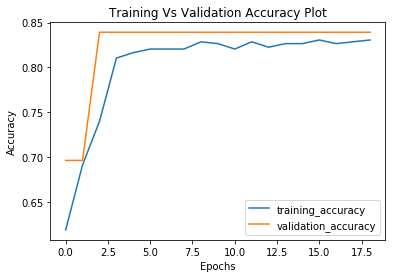

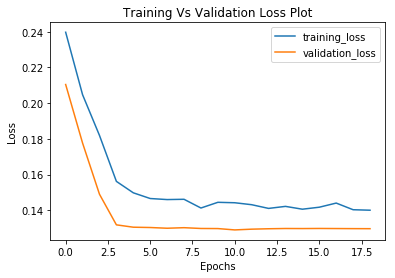

------------------------------------------------------------------------
Saving final model Final.hdf5


In [32]:

    
model = Sequential()
model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
sgd = optimizers.SGD(lr=0.1, momentum=0.90, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
ch = ModelCheckpoint('DLBestEnsemble.hdf5', monitor='acc', verbose=1, save_best_only=True, mode='max',period=1)
relr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001, mode='min', verbose=1, min_delta=1E-6)
callbacks_list = [es,ch,relr]

history = model.fit(X_train,y_train,epochs=5000, verbose=2, shuffle=True, batch_size=64, validation_split=0.1, callbacks=callbacks_list)
model.summary()

print('\nPerformance Charts\n')

pyplot.figure()

pyplot.plot(history.history['acc'], label='training_accuracy')
pyplot.plot(history.history['val_acc'], label='validation_accuracy')
pyplot.title('Training Vs Validation Accuracy Plot',loc='center')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.legend()

pyplot.show()

pyplot.figure()

pyplot.plot(history.history['loss'], label='training_loss')    
pyplot.plot(history.history['val_loss'], label='validation_loss')
pyplot.title('Training Vs Validation Loss Plot')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()

pyplot.show() 
        
print('------------------------------------------------------------------------')

print('Saving final model Final.hdf5')
model.save("FinalEnsemble.hdf5")

In [33]:
# Evaluate model
model.evaluate(x=X_test,y=y_test)

62/62 [==============================] - 0s 97us/step


[0.16933167845972122, 0.7903225729542394]

In [34]:
# Make predictions on X_test
predictions = model.predict_classes(X_test)
predictions

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1], dtype=int64)

In [35]:
# Use argmax to select the prediction values from binary array y (Output from DL model trained above)
y_test.argmax(axis=1)

array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1], dtype=int64)

In [36]:
# Print confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test.argmax(axis=1),predictions))

[[ 7 12]
 [ 1 42]]


In [37]:
# Print a classification report
print(metrics.classification_report(y_test.argmax(axis=1),predictions))

              precision    recall  f1-score   support

           0       0.88      0.37      0.52        19
           1       0.78      0.98      0.87        43

   micro avg       0.79      0.79      0.79        62
   macro avg       0.83      0.67      0.69        62
weighted avg       0.81      0.79      0.76        62



In [38]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test.argmax(axis=1),predictions))

0.7903225806451613


In [39]:
# Use the final trained model to make predictions on test dataset for final submission
test_predictions = model.predict_classes(t)
test_predictions

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [40]:
# Import the test dataset and add predictions as the Loan_Status column
dft2 = pd.read_csv('test.csv')
dft2['Loan_Status'] = test_predictions

In [41]:
# Drop all the unnecessary columns
dft2 = dft2.drop(['Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area'],axis=1)
dft2.head()

,Loan_ID,Loan_Status
0,LP001015,1
1,LP001022,1
2,LP001031,1
3,LP001035,1
4,LP001051,1


In [42]:
# Convert the numeric predictions back to Y/N categorical predictions for final submission
dft2['Loan_Status'] = dft2['Loan_Status'].map(lambda x: 'Y' if x == 1 else 'N')
dft2.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y


In [43]:
# Save the final predictions made using Advanced Stacking Ensemble technique
dft2.to_csv('Ensemble.csv', index=False)